In [1]:
import os
import numpy as np
import pandas as pd
import math
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import LeavePOut
from skimage.morphology import remove_small_objects
import nibabel as nib
import scipy.stats
from scipy.stats import mannwhitneyu, ttest_ind, ttest_rel, ranksums, wilcoxon
from scipy.ndimage import gaussian_filter
from scipy.ndimage import binary_dilation, binary_erosion
from scipy.stats import norm
from collections import Counter
import random
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler, Normalizer
from scipy.stats import sem
import matplotlib.colors as mcolors
from statsmodels.stats.multitest import multipletests

from matplotlib.ticker import FuncFormatter

In [63]:
def threshold_tract_vol_by_intensity(vol_tract,intensity_val):
    vol_output = np.zeros_like(vol_tract)
    vol_output[vol_tract == intensity_val] = 1
    #vol_output[vol_tract == intensity_val + 1000] = 1
    return vol_output


def extract_mean_diff(vol,vol_tract,erode_vol=False):

    vol = np.nan_to_num(vol)
    
    if np.count_nonzero(vol_tract) < 20:
        print("potentially bad vol!")
    
    ## small dilation kernel really for brainstem seg to avoid synthseg weird segmentation at boundaries/capture lesions
    if erode_vol is True:
        strel_dil = np.ones((5, 5, 5))
        vol_tract = binary_dilation(vol_tract, structure=strel_dil)
    
    masked_array = vol * vol_tract
    mean_intensity = np.nan_to_num(np.sum(masked_array)/np.sum(vol_tract))

    return mean_intensity


def extract_volume(vol,erode_vol=False):
    vol = np.nan_to_num(vol)
    
    ## small dilation kernel really for brainstem seg to avoid synthseg weird segmentation at boundaries/capture lesions
    if erode_vol is True:
        strel_dil = np.ones((5, 5, 5))
        vol = binary_dilation(vol, structure=strel_dil)
    
    if np.count_nonzero(vol) < 20:
        print(" ")
        print("   potentially bad vol!")
        print(" ")

    return np.count_nonzero(vol)


    
def list_base_subdirectories(path):
    return [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]


def find_repeats(lst):
    counts = {}
    for item in lst:
        if item in counts:
            counts[item] += 1
        else:
            counts[item] = 1  
    repeats = [item for item, count in counts.items() if count > 1]   
    return repeats

    
    
# AUC comparison adapted from
# https://github.com/Netflix/vmaf/
def compute_midrank(x):
    """Computes midranks.
    Args:
       x - a 1D numpy array
    Returns:
       array of midranks
    """
    J = np.argsort(x)
    Z = x[J]
    N = len(x)
    T = np.zeros(N, dtype=float)
    i = 0
    while i < N:
        j = i
        while j < N and Z[j] == Z[i]:
            j += 1
        T[i:j] = 0.5*(i + j - 1)
        i = j
    T2 = np.empty(N, dtype=float)
    # Note(kazeevn) +1 is due to Python using 0-based indexing
    # instead of 1-based in the AUC formula in the paper
    T2[J] = T + 1
    return T2

# adapted from https://github.com/Netflix/vmaf/
def fastDeLong(predictions_sorted_transposed, label_1_count):
    """
    The fast version of DeLong's method for computing the covariance of
    unadjusted AUC.
    Args:
       predictions_sorted_transposed: a 2D numpy.array[n_classifiers, n_examples]
          sorted such as the examples with label "1" are first
    Returns:
       (AUC value, DeLong covariance)
    Reference:
     @article{sun2014fast,
       title={Fast Implementation of DeLong's Algorithm for
              Comparing the Areas Under Correlated Receiver Operating Characteristic Curves},
       author={Xu Sun and Weichao Xu},
       journal={IEEE Signal Processing Letters},
       volume={21},
       number={11},
       pages={1389--1393},
       year={2014},
       publisher={IEEE}
     }
    """
    # Short variables are named as they are in the paper
    m = label_1_count
    n = predictions_sorted_transposed.shape[1] - m
    positive_examples = predictions_sorted_transposed[:, :m]
    negative_examples = predictions_sorted_transposed[:, m:]
    k = predictions_sorted_transposed.shape[0]

    tx = np.empty([k, m], dtype=float)
    ty = np.empty([k, n], dtype=float)
    tz = np.empty([k, m + n], dtype=float)
    for r in range(k):
        tx[r, :] = compute_midrank(positive_examples[r, :])
        ty[r, :] = compute_midrank(negative_examples[r, :])
        tz[r, :] = compute_midrank(predictions_sorted_transposed[r, :])
    aucs = tz[:, :m].sum(axis=1) / m / n - float(m + 1.0) / 2.0 / n
    v01 = (tz[:, :m] - tx[:, :]) / n
    v10 = 1.0 - (tz[:, m:] - ty[:, :]) / m
    sx = np.cov(v01)
    sy = np.cov(v10)
    delongcov = sx / m + sy / n
    return aucs, delongcov

# adapted from https://github.com/Netflix/vmaf/
def calc_pvalue(aucs, sigma):
    """Computes log(10) of p-values.
    Args:
       aucs: 1D array of AUCs
       sigma: AUC DeLong covariances
    Returns:
       log10(pvalue)
    """
    l = np.array([[1, -1]])
    z = np.abs(np.diff(aucs)) / np.sqrt(np.dot(np.dot(l, sigma), l.T))
    return np.log10(2) + scipy.stats.norm.logsf(z, loc=0, scale=1) / np.log(10)

# adapted from https://github.com/Netflix/vmaf/
def compute_ground_truth_statistics(ground_truth):
    assert np.array_equal(np.unique(ground_truth), [0, 1])
    order = (-ground_truth).argsort()
    label_1_count = int(ground_truth.sum())
    return order, label_1_count

# adapted from https://github.com/Netflix/vmaf/
def delong_roc_variance(ground_truth, predictions):
    """
    Computes ROC AUC variance for a single set of predictions
    Args:
       ground_truth: np.array of 0 and 1
       predictions: np.array of floats of the probability of being class 1
    """
    order, label_1_count = compute_ground_truth_statistics(ground_truth)
    predictions_sorted_transposed = predictions[np.newaxis, order]
    aucs, delongcov = fastDeLong(predictions_sorted_transposed, label_1_count)
    assert len(aucs) == 1, "There is a bug in the code, please forward this to the developers"
    return aucs[0], delongcov

# adapted from https://github.com/Netflix/vmaf/
def delong_roc_test(ground_truth, predictions_one, predictions_two):
    """
    Computes log(p-value) for hypothesis that two ROC AUCs are different
    Args:
       ground_truth: np.array of 0 and 1
       predictions_one: predictions of the first model,
          np.array of floats of the probability of being class 1
       predictions_two: predictions of the second model,
          np.array of floats of the probability of being class 1
    """
    order, label_1_count = compute_ground_truth_statistics(ground_truth)
    predictions_sorted_transposed = np.vstack((predictions_one, predictions_two))[:, order]
    aucs, delongcov = fastDeLong(predictions_sorted_transposed, label_1_count)

    return calc_pvalue(aucs, delongcov)


def identify_non_outliers(data):
        q1 = np.percentile(data, 25)
        q3 = np.percentile(data, 75)
        iqr = q3 - q1
        lower_bound = q1 - 3 * iqr
        upper_bound = q3 + 3 * iqr
        non_outliers = data[(data >= lower_bound) & (data <= upper_bound)]
        outliers = data[(data < lower_bound) | (data > upper_bound)]
        return non_outliers, outliers


def plot_differences(label_names, controls, patients, patients_followup, ylab_name, fig_save_path, y_lower, y_upper, figsize):
    plt.rcParams['font.family'] = 'Arial'
    plt.rcParams['mathtext.default'] = 'regular'

    spacing = 30

    # Assuming 'BSB_intensity_list' and label_names are predefined
    num_labels = len(label_names)
    print("num labels is: ", num_labels)

    fig = plt.figure(figsize=figsize)
    plot_area = [0.3, 0.3, 0.6, 0.6]
    ax = fig.add_axes(plot_area)

    p_array = []

    y_max = max(np.max(controls), np.max(patients), np.max(patients_followup))
    comparisons_list = []


    for i, label_name in enumerate(label_names):
        control_data = controls[:, i]
        patient_data = patients[:, i]
        followup_data = patients_followup[:, i]
        
        # only show extreme outliers (Q1/Q3 += 3IQ)
        control_non_outliers, control_outliers = identify_non_outliers(control_data)
        patient_non_outliers, patient_outliers = identify_non_outliers(patient_data)
        followup_non_outliers, followup_outliers = identify_non_outliers(followup_data)

        # Compute positions for the violin plots
        control_position = i * spacing - 3
        patient_position = i * spacing + 5
        followup_position = i * spacing + 13

        # Create violin plots
        data = [control_non_outliers, patient_non_outliers, followup_non_outliers]
        positions = [control_position, patient_position, followup_position]
        vp = plt.violinplot(data, positions=positions, widths=8, showextrema=False, showmedians=True)

        # Styling the violin plots
        colors = ['#1F85DE', '#DE781F', '#8EDE2F']  # Adding a greenish color for follow-up
        for j, body in enumerate(vp['bodies']):
            body.set_facecolor(colors[j])
            body.set_edgecolor('black')
            body.set_alpha(0.7)

        medianprops = dict(linestyle='-', linewidth=2, color='black')
        boxprops = dict(linestyle='-', linewidth=2, color='black')
        flierprops = dict(marker='o', markerfacecolor='none', markersize=8, linestyle='none', markeredgecolor='black',markeredgewidth=2)
        whiskerprops = dict(linewidth=2)

        plt.boxplot([control_data],positions=[control_position],widths=3,flierprops=flierprops,whiskerprops=whiskerprops,medianprops=medianprops,boxprops=boxprops, showfliers=False)
        plt.boxplot([patient_data],positions=[patient_position],widths=3,flierprops=flierprops,whiskerprops=whiskerprops,medianprops=medianprops,boxprops=boxprops, showfliers=False)
        plt.boxplot([followup_data], positions=[followup_position],widths=3,flierprops=flierprops,whiskerprops=whiskerprops,medianprops=medianprops,boxprops=boxprops, showfliers=False)

        # Plot the extreme outliers
        plt.scatter(np.full_like(control_outliers, control_position), control_outliers,
                    color='red', marker='+', zorder=3, s=125, linewidths=2.5)
        plt.scatter(np.full_like(patient_outliers, patient_position), patient_outliers,
                    color='red', marker='+', zorder=3, s=125, linewidths=2.5)
        plt.scatter(np.full_like(followup_outliers, followup_position), followup_outliers,
                    color='red', marker='+', zorder=3, s=125, linewidths=2.5)
        
        ## cp: control/patient
        ## pf: patient/patient followup
        ## cf: control/patient followup
        # Significance testing and brackets
        stat_cp, p_cp = ranksums(control_data, patient_data, alternative='two-sided')
        stat_pf, p_pf = wilcoxon(patient_data, followup_data, alternative='two-sided')
        stat_cf, p_cf = ranksums(control_data, followup_data, alternative='two-sided')


        comparisons = [(control_position, patient_position, p_cp), 
                       (patient_position, followup_position, p_pf), 
                       (control_position, followup_position, p_cf)]

        comparisons_list.append(comparisons)


    cp_pval_list = []
    ppf_pval_list = []
    cpf_pval_list = []

    for i, label_name in enumerate(label_names):
        comparisons_ele = comparisons_list[i]
        cp_pval_list.append(comparisons_ele[0][2])
        ppf_pval_list.append(comparisons_ele[1][2])
        cpf_pval_list.append(comparisons_ele[2][2])

    cp_pval_list_corrected = multipletests(cp_pval_list, method='fdr_bh')[1] 
    ppf_pval_list_corrected = multipletests(ppf_pval_list, method='fdr_bh')[1]   
    cpf_pval_list_corrected = multipletests(cpf_pval_list, method='fdr_bh')[1]

    all_pval_corrected_list = [cp_pval_list_corrected, ppf_pval_list_corrected, cpf_pval_list_corrected]


    for i, label_name in enumerate(label_names):

        comparisons_ele = comparisons_list[i]

        print(label_name," c-p pval: ", comparisons_ele[0][2])
        print(label_name," p-pf pval: ", comparisons_ele[1][2])
        print(label_name," c-pf pval: ", comparisons_ele[2][2])

        print(label_name," c-p pval CORRECTED: ", all_pval_corrected_list[0][i])
        print(label_name," p-pf pval CORRECTED: ", all_pval_corrected_list[1][i])
        print(label_name," c-pf pval CORRECTED: ", all_pval_corrected_list[2][i])
        print(" ")


        ## plotting the bar for significance...who knew it's this annoying
        ind = 0
        single_star_counter = 0.  # vary heights if same significance (i.e., * for
                                  # both c-pb and c-p2yf) as to avoid clash
        for x1, x2, p in comparisons_ele:
            p_corrected = all_pval_corrected_list[ind][i]
            if p_corrected < 0.05:
                if p_corrected <= 0.01:
                    text = '**'
                else:
                    text = '*'
                if ind == 0:
                    bar_ht = 0
                elif ind == 1:
                    bar_ht = (y_upper-y_lower)/20
                else:
                    bar_ht = (y_upper-y_lower)/10
                y, h, col = max(max(controls[:, i]), max(patients[:, i]), max(followup[:, i])) + (y_upper-y_lower)/20, (y_upper-y_lower)/100, 'k'
                plt.plot([x1, x1, x2, x2], [y+bar_ht, y+h+bar_ht, y+h+bar_ht, y+bar_ht], lw=2, c=col)
                plt.text((x1+x2)*.5, y+h+bar_ht-(y_upper-y_lower)/25, text, ha='center', va='bottom', color=col, fontsize=38)
                ind += 1
            else:
                ind += 1
                continue  # No significant difference found for this comparison




    # Update aesthetics
    positions = [i * spacing + 5 for i in range(num_labels)]  # Adjust centering for ticks
    plt.xticks(positions, label_names, rotation=45, fontsize=28, fontweight='regular')
    plt.yticks(fontsize=25, fontweight='regular')



    #plt.ylabel(r'Mean Diffusivity $\times 10^{-3}$', fontsize=32, fontweight='regular')
    plt.ylabel(ylab_name, fontsize=32, fontweight='regular')
    plt.ylim([y_lower, y_upper])
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend(handles=[plt.Line2D([], [], marker="o", markeredgecolor='black', markersize=22, linestyle="", color=color, label=label)
                        for color, label in zip(colors, ['Controls', 'PD (baseline)', 'PD (2-year follow-up)'])], fontsize=22, prop={'size': 22, 'weight': 'regular'})

    # to change legend loc, add: ,loc='lower left',
    plt.tight_layout()
    plt.savefig(fig_save_path, dpi=300)
    plt.show()
    
    
    
def roc(controls, patients, scaler=None, flip_preds=False, C=0.1, max_iter=1000, penalty='l2', solver='lbfgs'):
 

    # C/penalty depracated here since this was for an older log. regression-based classifier. not needed for LDA
    X = np.vstack((controls, patients))
    y = np.hstack((np.zeros(controls.shape[0]), np.ones(patients.shape[0])))
    
    tot = len(controls) + len(patients)
    
    # only needed if multiple features (i.e., not single-feat brainstem)
    if scaler is None:
        X_normalized = X
    else:
        X_normalized = scaler.fit_transform(X)

    loo = LeaveOneOut()

    all_y_test = []
    all_y_scores = []
    y_test_run = []
    y_scores_run = []

    for train_index, test_index in loo.split(X_normalized):
        X_train, X_test = X_normalized[train_index], X_normalized[test_index]
        y_train, y_test = y[train_index], y[test_index]

        clf = LDAClassifier()
        clf.fit(X_train, y_train)
        if flip_preds:
            y_score = clf.predict_proba(X_test)[:, 0]
        else: 
            y_score = clf.predict_proba(X_test)[:, 1]
        y_test_run.extend(y_test)
        y_scores_run.extend(y_score)

    all_y_test.extend(y_test_run)
    all_y_scores.extend(y_scores_run)

    # Compute ROC from aggregate preds
    fpr, tpr, _ = roc_curve(all_y_test, all_y_scores)
    roc_auc = auc(fpr, tpr)
    
    return all_y_test, all_y_scores, fpr, tpr, roc_auc



class LDAClassifier:
    
    def __init__(self):
        self.classes_ = None
        self.means_ = None
        self.priors_ = None
        self.covariance_ = None
        self.covariance_inv_ = None

    def fit(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y)
        self.classes_ = np.unique(y)
        n_features = X.shape[1]
        n_classes = len(self.classes_)

        self.means_ = np.zeros((n_classes, n_features))
        self.priors_ = np.zeros(n_classes)
        cov = np.zeros((n_features, n_features))

        # Compute class means, priors, and pooled covar
        for idx, cls in enumerate(self.classes_):
            X_cls = X[y == cls]
            self.means_[idx] = X_cls.mean(axis=0)
            self.priors_[idx] = 1/len(self.classes_)  # flat prior
            cov += np.cov(X_cls, rowvar=False, bias=False) * X_cls.shape[0]

        cov /= X.shape[0]
        self.covariance_ = cov
        self.covariance_inv_ = np.linalg.inv(cov)

    def predict(self, X):
        scores = self.decision_function(X)
        y_pred = self.classes_[np.argmax(scores, axis=1)]
        return y_pred

    def decision_function(self, X):
        X = np.asarray(X)
        scores = []
        for mean, prior in zip(self.means_, self.priors_):
            score = X @ self.covariance_inv_ @ mean - 0.5 * mean @ self.covariance_inv_ @ mean + np.log(prior)
            scores.append(score)
        return np.array(scores).T

    def predict_proba(self, X):
        scores = self.decision_function(X)
        exp_scores = np.exp(scores)
        # Norm
        probas = exp_scores / exp_scores.sum(axis=1, keepdims=True)
        return probas



In [3]:
base_path_bsb_controls = "/Users/markolchanyi/Desktop/BSB_validation/PPMI_controls/"
base_path_bsb_patients = "/Users/markolchanyi/Desktop/BSB_validation/PPMI_patients/"
base_path_bsb_patients_followup = "/Users/markolchanyi/Desktop/BSB_validation/PPMI_patients_followup/"


####
DTI_volume_to_use = "fa"

## 1mm
blur_sigma = 1

#######################################

case_list_control = [
    '3106', 
    '3109', 
    '3112', 
    '3114', 
    '3115', 
    '3157',
    '3160', 
    '3165', 
    '3169', 
    '3171', 
    '3172', 
    '3188', 
    '3191', 
    '3300', 
    '3370', 
    '3389', 
    '3390', 
    '3554', 
    '3555', 
    '3563', 
    '3569', 
    '3570', 
    '3571', 
    '3572', 
    '3756', 
    '3759', 
    '3765', 
    '3767', 
    '3768', 
    '3769', 
    '3779', 
    '3803', 
    '3804', 
    '3805', 
    '3806', 
    '3807', 
    '3809', 
    '3811', 
    '3812', 
    '3813', 
    '3816', 
    '3817', 
    '3853', 
    '3855', 
    '3857',
    '4004', 
    '4010',
    '4018', 
    '4032',
    '4067',
    '4085',
    '4139']

case_list_patient = [
    '3107', 
    '3108', 
    '3111', 
    '3120', 
    '3124', 
    '3126', 
    '3128', 
    '3131', 
    '3132', 
    '3150', 
    '3154', 
    '3168', 
    '3173', 
    '3174', 
    '3175', 
    '3179', 
    '3181', 
    '3182', 
    '3184', 
    '3185', 
    '3373', 
    '3377', 
    '3564', 
    '3567', 
    '3574', 
    '3575', 
    '3585', 
    '3587', 
    '3588', 
    '3591', 
    '3752', 
    '3757', 
    '3758', 
    '3760', 
    '3762', 
    '3770', 
    '3771', 
    '3775', 
    '3777', 
    '3778', 
    '3780', 
    '3781', 
    '3808', 
    '3814', 
    '3815', 
    '3819', 
    '3823', 
    '3825', 
    '3826', 
    '3830', 
    '3831', 
    '3832', 
    '3834', 
    '3838', 
    '4005', 
    '4012', 
    '4013', 
    '4020', 
    '4022', 
    '4029', 
    '4030', 
    '4034', 
    '4038', 
    '40534', 
    '4083', 
    '41488', 
    '40366', 
    '50028', 
    '50901', 
    '51632', 
    '52678', 
    '55395']


### these are matched cases
case_list_patient_followup = case_list_patient



#######################################################################################################

print("length of control cases: ", len(case_list_control))
print("length of patient cases: ", len(case_list_patient))
print("length of patient followup cases: ", len(case_list_patient_followup))


repeats = find_repeats(case_list_patient)
if repeats:
    print("Repeats in control set!!!:", repeats)
    
repeats = find_repeats(case_list_patient)
if repeats:
    print("Repeats in patient set!!!:", repeats)


BSB_intensity_list = [1001,2001,1002,2002,1003,2003,1004,2004,1005,2005,1006,2006,1007,2007,1008,2008]
BSB_intensity_list_left = [1001,1002,1003,1004,1005,1006,1007,1008]
BSB_intensity_list_right = [2001,2002,2003,2004,2005,2006,2007,2008]



tractseg_volume_list = ["IFO_left",
                        "IFO_right",
                        "OR_left",
                        "OR_right",
                        "POPT_left",
                        "POPT_right",
                        "CG_left",
                        "CG_right",
                        "STR_left",
                        "STR_right",
                        "ILF_left",
                        "ILF_right",
                        "CC",
                        "FX_left",
                        "FX_right"]



cwm_volume_list = ["cwm_left","cwm_right"]

label_names = ["left MLc", 
               "right MLc",
               "left SCP",
               "right SCP",
               "left LFB",
               "right LFB",
               "left MHB",
               "right MHB",
               "left Bic",
               "right Bic",
               "left MLr",
               "right MLr",
               "left MLF",
               "right MLF",
               "left CTG",
               "right CTG"]

label_names_nolr = ["MLc", 
                   "SCP",
                   "LFB",
                   "MHB",
                   "Bic",
                   "MLr",
                   "MLF",
                   "CTG"]

length of control cases:  52
length of patient cases:  72
length of patient followup cases:  72


In [4]:
'''
for count_case, case in enumerate(case_list_patient):
    print("starting ",case)
    dir_case = os.path.join(base_path_bsb_patients,case,'DTI_gated',list_base_subdirectories(os.path.join(base_path_bsb_patients,case,'DTI_gated'))[0])
    dir_tractseg = os.path.join(dir_case,'tractseg_outputs','bundle_segmentations')
   
    dir_md = os.path.join(dir_case,"bsb_outputs_attention",DTI_volume_to_use,"_1mm.nii.gz")

    osstr = "mrmath"
    for count_tract, tract in enumerate(tractseg_cortical_volume_list):
        osstr += " "
        osstr += os.path.join(dir_tractseg,tract + ".nii.gz")
    osstr += " max " + os.path.join(dir_tractseg,"all_tracts.nii.gz") + " -force"
        
    os.system(osstr)
    os.system("mri_convert " + os.path.join(dir_tractseg,"all_tracts.nii.gz") + " " + os.path.join(dir_tractseg,"all_tracts_conformed.nii.gz") + " -rl " + dir_md + " -rt nearest -odt float")
    '''

'\nfor count_case, case in enumerate(case_list_patient):\n    print("starting ",case)\n    dir_case = os.path.join(base_path_bsb_patients,case,\'DTI_gated\',list_base_subdirectories(os.path.join(base_path_bsb_patients,case,\'DTI_gated\'))[0])\n    dir_tractseg = os.path.join(dir_case,\'tractseg_outputs\',\'bundle_segmentations\')\n   \n    dir_md = os.path.join(dir_case,"bsb_outputs_attention",DTI_volume_to_use,"_1mm.nii.gz")\n\n    osstr = "mrmath"\n    for count_tract, tract in enumerate(tractseg_cortical_volume_list):\n        osstr += " "\n        osstr += os.path.join(dir_tractseg,tract + ".nii.gz")\n    osstr += " max " + os.path.join(dir_tractseg,"all_tracts.nii.gz") + " -force"\n        \n    os.system(osstr)\n    os.system("mri_convert " + os.path.join(dir_tractseg,"all_tracts.nii.gz") + " " + os.path.join(dir_tractseg,"all_tracts_conformed.nii.gz") + " -rl " + dir_md + " -rt nearest -odt float")\n    '

In [5]:
##### reformat at tractseg volumes
'''
for case in case_list_control_missing:
    dir_case = os.path.join(base_path_bsb_controls,case,'DTI_gated',list_base_subdirectories(os.path.join(base_path_bsb_controls,case,'DTI_gated'))[0])
    dir_seg = os.path.join(dir_case,"bsb_outputs_attention","unet_predictions_newfa","unet_results","wmunet.crfseg.mgz")
    dir_vol = os.path.join(dir_case,"bsb_outputs_attention",DTI_volume_to_use + "_1mm.nii.gz")
    print("starting control: ",case)
    if os.path.isfile(dir_vol):
        os.system("mri_convert " + dir_vol + " " + os.path.join(dir_case,"bsb_outputs_attention",DTI_volume_to_use + "_1mm_conformed.nii.gz") + " -rl " + dir_seg + " -odt float")
            
    else:
        print("full vol does not exist!")
        
        
for case in case_list_patient_missing:
    dir_case = os.path.join(base_path_bsb_patients,case,'DTI_gated',list_base_subdirectories(os.path.join(base_path_bsb_patients,case,'DTI_gated'))[0])
    dir_seg = os.path.join(dir_case,"bsb_outputs_attention","unet_predictions_newfa","unet_results","wmunet.crfseg.mgz")
    dir_vol = os.path.join(dir_case,"bsb_outputs_attention",DTI_volume_to_use + "_1mm.nii.gz")
    print("starting patient: ",case)
    if os.path.isfile(dir_vol):
        os.system("mri_convert " + dir_vol + " " + os.path.join(dir_case,"bsb_outputs_attention",DTI_volume_to_use + "_1mm_conformed.nii.gz") + " -rl " + dir_seg + " -odt float")
            
    else:
        print("full vol does not exist!")
        
for case in case_list_patient_missing:
    dir_case = os.path.join(base_path_bsb_patients_followup,case,'DTI_gated',list_base_subdirectories(os.path.join(base_path_bsb_patients_followup,case,'DTI_gated'))[0])
    dir_seg = os.path.join(dir_case,"bsb_outputs_attention","unet_predictions_newfa","unet_results","wmunet.crfseg.mgz")
    dir_vol = os.path.join(dir_case,"bsb_outputs_attention",DTI_volume_to_use + "_1mm.nii.gz")
    print("starting patient: ",case)
    if os.path.isfile(dir_vol):
        os.system("mri_convert " + dir_vol + " " + os.path.join(dir_case,"bsb_outputs_attention",DTI_volume_to_use + "_1mm_conformed.nii.gz") + " -rl " + dir_seg + " -odt float")
            
    else:
        print("full vol does not exist!")
 '''           

'\nfor case in case_list_control_missing:\n    dir_case = os.path.join(base_path_bsb_controls,case,\'DTI_gated\',list_base_subdirectories(os.path.join(base_path_bsb_controls,case,\'DTI_gated\'))[0])\n    dir_seg = os.path.join(dir_case,"bsb_outputs_attention","unet_predictions_newfa","unet_results","wmunet.crfseg.mgz")\n    dir_vol = os.path.join(dir_case,"bsb_outputs_attention",DTI_volume_to_use + "_1mm.nii.gz")\n    print("starting control: ",case)\n    if os.path.isfile(dir_vol):\n        os.system("mri_convert " + dir_vol + " " + os.path.join(dir_case,"bsb_outputs_attention",DTI_volume_to_use + "_1mm_conformed.nii.gz") + " -rl " + dir_seg + " -odt float")\n            \n    else:\n        print("full vol does not exist!")\n        \n        \nfor case in case_list_patient_missing:\n    dir_case = os.path.join(base_path_bsb_patients,case,\'DTI_gated\',list_base_subdirectories(os.path.join(base_path_bsb_patients,case,\'DTI_gated\'))[0])\n    dir_seg = os.path.join(dir_case,"bsb_outpu

In [6]:
######## for MD ########
##### reformat at tractseg volumes
'''
for case in case_list_patient_missing:
    dir_case = os.path.join(base_path_bsb_patients,case,'DTI_gated',list_base_subdirectories(os.path.join(base_path_bsb_patients,case,'DTI_gated'))[0])
    dir_seg = os.path.join(dir_case,"bsb_outputs_attention","samseg_labels","seg.mgz")
    dir_vol = os.path.join(dir_case,"bsb_outputs_attention",DTI_volume_to_use + "_1mm_conformed.nii.gz")
    print("starting: ",case)
    if os.path.isfile(dir_vol):
        os.system("mri_convert " + dir_seg + " " + os.path.join(dir_case,"bsb_outputs_attention","samseg_labels","seg_conformed.mgz") + " -rl " + dir_vol + " -rt nearest -odt float")
            
    else:
        print("full vol does not exist!")
        
for case in case_list_patient_missing:
    dir_case = os.path.join(base_path_bsb_patients_followup,case,'DTI_gated',list_base_subdirectories(os.path.join(base_path_bsb_patients,case,'DTI_gated'))[0])
    dir_seg = os.path.join(dir_case,"bsb_outputs_attention","samseg_labels","seg.mgz")
    dir_vol = os.path.join(dir_case,"bsb_outputs_attention",DTI_volume_to_use + "_1mm_conformed.nii.gz")
    print("starting: ",case)
    if os.path.isfile(dir_vol):
        os.system("mri_convert " + dir_seg + " " + os.path.join(dir_case,"bsb_outputs_attention","samseg_labels","seg_conformed.mgz") + " -rl " + dir_vol + " -rt nearest -odt float")
            
    else:
        print("full vol does not exist!")
        
for case in case_list_control_missing:
    dir_case = os.path.join(base_path_bsb_controls,case,'DTI_gated',list_base_subdirectories(os.path.join(base_path_bsb_controls,case,'DTI_gated'))[0])
    dir_seg = os.path.join(dir_case,"bsb_outputs_attention","samseg_labels","seg.mgz")
    dir_vol = os.path.join(dir_case,"bsb_outputs_attention",DTI_volume_to_use + "_1mm_conformed.nii.gz")
    print("starting: ",case)
    if os.path.isfile(dir_vol):
        os.system("mri_convert " + dir_seg + " " + os.path.join(dir_case,"bsb_outputs_attention","samseg_labels","seg_conformed.mgz") + " -rl " + dir_vol + " -rt nearest -odt float")
            
    else:
        print("full vol does not exist!")
        
 '''       

'\nfor case in case_list_patient_missing:\n    dir_case = os.path.join(base_path_bsb_patients,case,\'DTI_gated\',list_base_subdirectories(os.path.join(base_path_bsb_patients,case,\'DTI_gated\'))[0])\n    dir_seg = os.path.join(dir_case,"bsb_outputs_attention","samseg_labels","seg.mgz")\n    dir_vol = os.path.join(dir_case,"bsb_outputs_attention",DTI_volume_to_use + "_1mm_conformed.nii.gz")\n    print("starting: ",case)\n    if os.path.isfile(dir_vol):\n        os.system("mri_convert " + dir_seg + " " + os.path.join(dir_case,"bsb_outputs_attention","samseg_labels","seg_conformed.mgz") + " -rl " + dir_vol + " -rt nearest -odt float")\n            \n    else:\n        print("full vol does not exist!")\n        \nfor case in case_list_patient_missing:\n    dir_case = os.path.join(base_path_bsb_patients_followup,case,\'DTI_gated\',list_base_subdirectories(os.path.join(base_path_bsb_patients,case,\'DTI_gated\'))[0])\n    dir_seg = os.path.join(dir_case,"bsb_outputs_attention","samseg_labels"

In [7]:
##### for BSB ######

case_list_control_pruned = case_list_control
case_list_patient_pruned = case_list_patient

global_intensity_control = []
global_intensity_patient = []

csf_intensity_list_control = []
csf_intensity_list_patient = []

print("length of pruned patient cases: ", len(case_list_patient_pruned))
print("length of pruned control cases: ", len(case_list_control_pruned))
controls_bsb = np.zeros((len(case_list_control_pruned),len(BSB_intensity_list)))
patients_bsb = np.zeros((len(case_list_patient_pruned),len(BSB_intensity_list)))

controls_bsb_volume = np.zeros((len(case_list_control_pruned),len(BSB_intensity_list)))
patients_bsb_volume = np.zeros((len(case_list_patient_pruned),len(BSB_intensity_list)))

counter = 0
for case in case_list_control_pruned:
    print("starting controls: ",case)
    dir_case = os.path.join(base_path_bsb_controls,case,'DTI_gated',list_base_subdirectories(os.path.join(base_path_bsb_controls,case,'DTI_gated'))[0])
    vol = nib.load(os.path.join(dir_case,"bsb_outputs_attention", DTI_volume_to_use + "_1mm_conformed.nii.gz"))
    vol_np = vol.get_fdata()
    
    ## apply gaussian blur due to low SNR from poor recons...probably due to only single b0 in the sequence
    vol_np = gaussian_filter(vol_np, sigma=blur_sigma)
     
    vol_whole = nib.load(os.path.join(dir_case,"bsb_outputs_attention", DTI_volume_to_use + "_1mm.nii.gz"))
    vol_whole_np = vol_whole.get_fdata()
    
    tract_vol = nib.load(os.path.join(dir_case,"bsb_outputs_attention","unet_predictions_newfa","unet_results","wmunet.crfseg.mgz"))
    tract_vol_np = tract_vol.get_fdata()
                             
    samseg_vol = nib.load(os.path.join(dir_case,"bsb_outputs_attention","samseg_labels","seg.mgz"))
    samseg_vol_np = samseg_vol.get_fdata()
    
    
    counter_tract = 0
    for intensity in BSB_intensity_list:
        tract_vol_np_thresholded = threshold_tract_vol_by_intensity(tract_vol_np,intensity)
        mean_diff = extract_mean_diff(vol_np,tract_vol_np_thresholded)
        volm = extract_volume(tract_vol_np_thresholded)
        if mean_diff == 0:
            print("MEAN DIFF 0")
        controls_bsb[counter,counter_tract] = mean_diff
        controls_bsb_volume[counter,counter_tract] = volm
        counter_tract += 1

    counter += 1



counter = 0
for case in case_list_patient_pruned:
    print("starting patients: ",case)
    dir_case = os.path.join(base_path_bsb_patients,case,'DTI_gated',list_base_subdirectories(os.path.join(base_path_bsb_patients,case,'DTI_gated'))[0])
    vol = nib.load(os.path.join(dir_case,"bsb_outputs_attention", DTI_volume_to_use + "_1mm_conformed.nii.gz"))
    vol_np = vol.get_fdata()
    
    ## same deal 
    vol_np = gaussian_filter(vol_np, sigma=blur_sigma)
    
    vol_whole = nib.load(os.path.join(dir_case,"bsb_outputs_attention",DTI_volume_to_use + "_1mm.nii.gz"))
    vol_whole_np = vol_whole.get_fdata()
    
    tract_vol = nib.load(os.path.join(dir_case,"bsb_outputs_attention","unet_predictions_newfa","unet_results","wmunet.crfseg.mgz"))
    tract_vol_np = tract_vol.get_fdata()
                          
    samseg_vol = nib.load(os.path.join(dir_case,"bsb_outputs_attention","samseg_labels","seg.mgz"))
    samseg_vol_np = samseg_vol.get_fdata()
    
    
    counter_tract = 0
    for intensity in BSB_intensity_list:
        tract_vol_np_thresholded = threshold_tract_vol_by_intensity(tract_vol_np,intensity)
        mean_diff = extract_mean_diff(vol_np,tract_vol_np_thresholded)
        volm = extract_volume(tract_vol_np_thresholded)
        if mean_diff == 0:
            print("MEAN DIFF 0")
        patients_bsb[counter,counter_tract] = mean_diff
        patients_bsb_volume[counter,counter_tract] = volm
        counter_tract += 1
    
    counter += 1
    

    
case_list_patient_pruned_followup = case_list_patient
global_intensity_patient_followup = []
csf_intensity_list_patient_followup = []

print("length of pruned patient cases: ", len(case_list_patient_pruned_followup))
patients_bsb_followup = np.zeros((len(case_list_patient_pruned_followup),len(BSB_intensity_list)))
patients_bsb_followup_volume = np.zeros((len(case_list_patient_pruned_followup),len(BSB_intensity_list)))


counter = 0
for case in case_list_patient_pruned:
    print("starting patients: ",case)
    dir_case = os.path.join(base_path_bsb_patients_followup,case,'DTI_gated',list_base_subdirectories(os.path.join(base_path_bsb_patients_followup,case,'DTI_gated'))[0])
    vol = nib.load(os.path.join(dir_case,"bsb_outputs_attention",DTI_volume_to_use + "_1mm_conformed.nii.gz"))
    vol_np = vol.get_fdata()
    
    ## same deal
    vol_np = gaussian_filter(vol_np, sigma=blur_sigma)  ### low SNR for singl b0 PPMI
    
    vol_whole = nib.load(os.path.join(dir_case,"bsb_outputs_attention",DTI_volume_to_use + "_1mm.nii.gz"))
    vol_whole_np = vol_whole.get_fdata()
    
    tract_vol = nib.load(os.path.join(dir_case,"bsb_outputs_attention","unet_predictions_newfa","unet_results","wmunet.crfseg.mgz"))
    tract_vol_np = tract_vol.get_fdata()
                          
    samseg_vol = nib.load(os.path.join(dir_case,"bsb_outputs_attention","samseg_labels","seg.mgz"))
    samseg_vol_np = samseg_vol.get_fdata()
    
    counter_tract = 0
    for intensity in BSB_intensity_list:
        tract_vol_np_thresholded = threshold_tract_vol_by_intensity(tract_vol_np,intensity)
        mean_diff = extract_mean_diff(vol_np,tract_vol_np_thresholded)
        volm = extract_volume(tract_vol_np_thresholded)
        if mean_diff == 0:
            print("MEAN DIFF 0")
        patients_bsb_followup[counter,counter_tract] = mean_diff
        patients_bsb_followup_volume[counter,counter_tract] = volm
        counter_tract += 1
    
    counter += 1


length of pruned patient cases:  72
length of pruned control cases:  52
starting controls:  3106
starting controls:  3109
starting controls:  3112
starting controls:  3114
starting controls:  3115
starting controls:  3157
starting controls:  3160
starting controls:  3165
starting controls:  3169
starting controls:  3171
starting controls:  3172
potentially bad vol!
 
   potentially bad vol!
 
starting controls:  3188
starting controls:  3191
starting controls:  3300
starting controls:  3370
starting controls:  3389
starting controls:  3390
starting controls:  3554
starting controls:  3555
starting controls:  3563
starting controls:  3569
starting controls:  3570
starting controls:  3571
starting controls:  3572
starting controls:  3756
starting controls:  3759
starting controls:  3765
starting controls:  3767
starting controls:  3768
starting controls:  3769
potentially bad vol!
 
   potentially bad vol!
 
potentially bad vol!
 
   potentially bad vol!
 
potentially bad vol!
 
   poten

num labels is:  16
left MLc  c-p pval:  0.48152378787904226
left MLc  p-pf pval:  0.17985723282252541
left MLc  c-pf pval:  0.7923099298366538
left MLc  c-p pval CORRECTED:  0.8748610873198299
left MLc  p-pf pval CORRECTED:  0.20555112322574334
left MLc  c-pf pval CORRECTED:  0.8451305918257641
 
right MLc  c-p pval:  0.3063708473223097
right MLc  p-pf pval:  0.5862114697574744
right MLc  c-pf pval:  0.4444989151725851
right MLc  c-p pval CORRECTED:  0.8169889261928258
right MLc  p-pf pval CORRECTED:  0.5862114697574744
right MLc  c-pf pval CORRECTED:  0.5926652202301135
 
left SCP  c-p pval:  0.050631839501055355
left SCP  p-pf pval:  0.0019505849121215747
left SCP  c-pf pval:  0.6413156364074919
left SCP  c-p pval CORRECTED:  0.6348179186266446
left SCP  p-pf pval CORRECTED:  0.006241871718789039
left SCP  c-pf pval CORRECTED:  0.7893115525015285
 
right SCP  c-p pval:  0.10087262877577563
right SCP  p-pf pval:  0.00048216570448986575
right SCP  c-pf pval:  0.7154203384070713
right S

<ipython-input-2-1e8f84595b11>:347: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


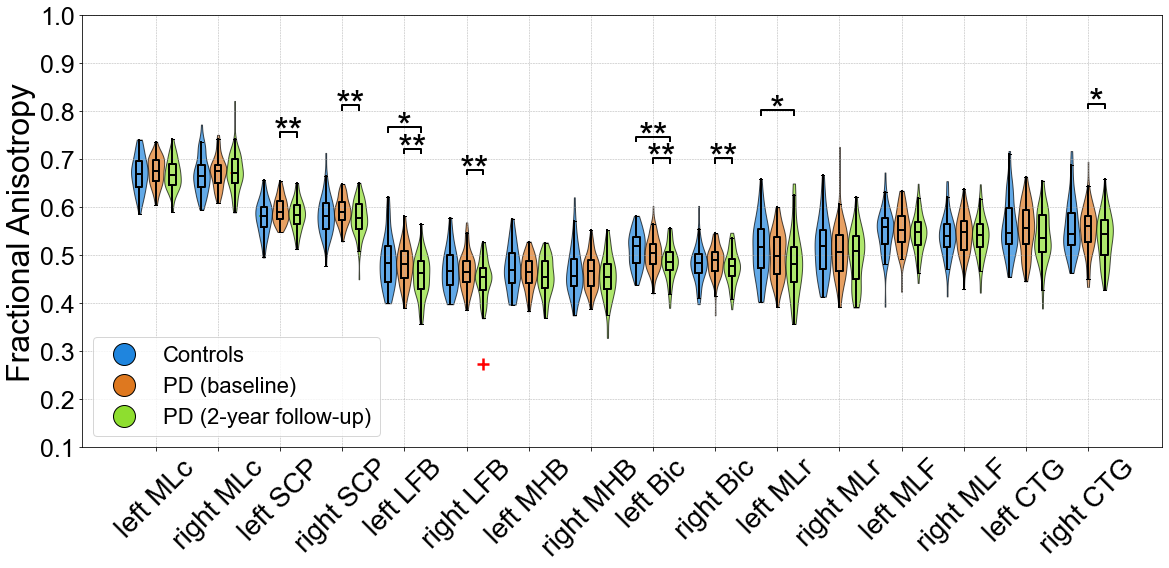

In [8]:
fig_save_path = '/Users/markolchanyi/Desktop/BSB_Figs/PPMI_violin_BSB.png'
ylab_name= 'Fractional Anisotropy'
labels = label_names
y_lower = 0.1
y_upper = 1.0
figsize = (25, 10)
controls = controls_bsb
patients = patients_bsb
followup = patients_bsb_followup


plot_differences(labels,controls,patients,followup,ylab_name,fig_save_path,y_lower,y_upper,figsize)

4.0
num labels is:  16
left MLc  c-p pval:  0.07804117054731265
left MLc  p-pf pval:  0.3429379717389185
left MLc  c-pf pval:  0.017797222710613226
left MLc  c-p pval CORRECTED:  0.3154458900620012
left MLc  p-pf pval CORRECTED:  0.5487007547822695
left MLc  c-pf pval CORRECTED:  0.1423777816849058
 
right MLc  c-p pval:  0.23010200062155017
right MLc  p-pf pval:  0.040533734758157774
right MLc  c-pf pval:  0.009316718236092675
right MLc  c-p pval CORRECTED:  0.3346938190858912
right MLc  p-pf pval CORRECTED:  0.18541444797033818
right MLc  c-pf pval CORRECTED:  0.1423777816849058
 
left SCP  c-p pval:  0.2577453395541419
left SCP  p-pf pval:  0.5187037985244896
left SCP  c-pf pval:  0.2620287875113275
left SCP  c-p pval CORRECTED:  0.33730572608867687
left SCP  p-pf pval CORRECTED:  0.7544782523992576
left SCP  c-pf pval CORRECTED:  0.4510581525150489
 
right SCP  c-p pval:  0.21195735902217816
right SCP  p-pf pval:  0.19487173708187944
right SCP  c-pf pval:  0.18713801452158885
right

<ipython-input-2-1e8f84595b11>:347: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


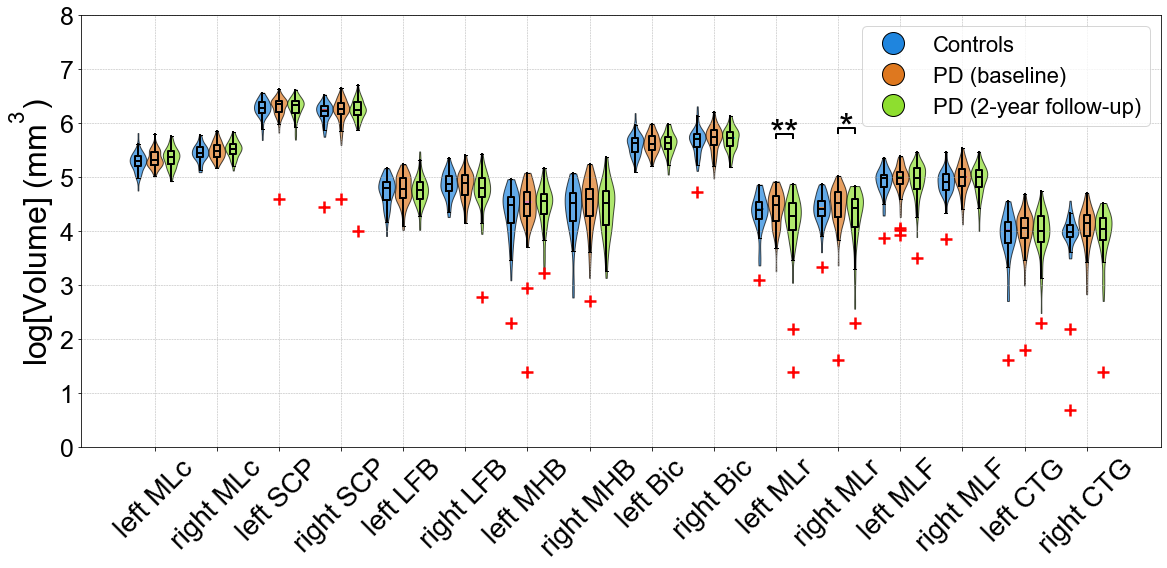

In [9]:
fig_save_path = '/Users/markolchanyi/Desktop/BSB_Figs/PPMI_violin_BSB_volume.png'
ylab_name= r'log$[Volume]$ $(mm^{3})$'
labels = label_names
y_lower = 0
y_upper = 8
figsize = (25, 10)
controls = np.log(controls_bsb_volume)
patients = np.log(patients_bsb_volume)
followup = np.log(patients_bsb_followup_volume)

print(np.min(patients_bsb_followup_volume))

plot_differences(labels,controls,patients,followup,ylab_name,fig_save_path,y_lower,y_upper,figsize)

<ipython-input-10-91c83a833574>:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjusts subplot params so that the subplot(s) fits in to the figure area


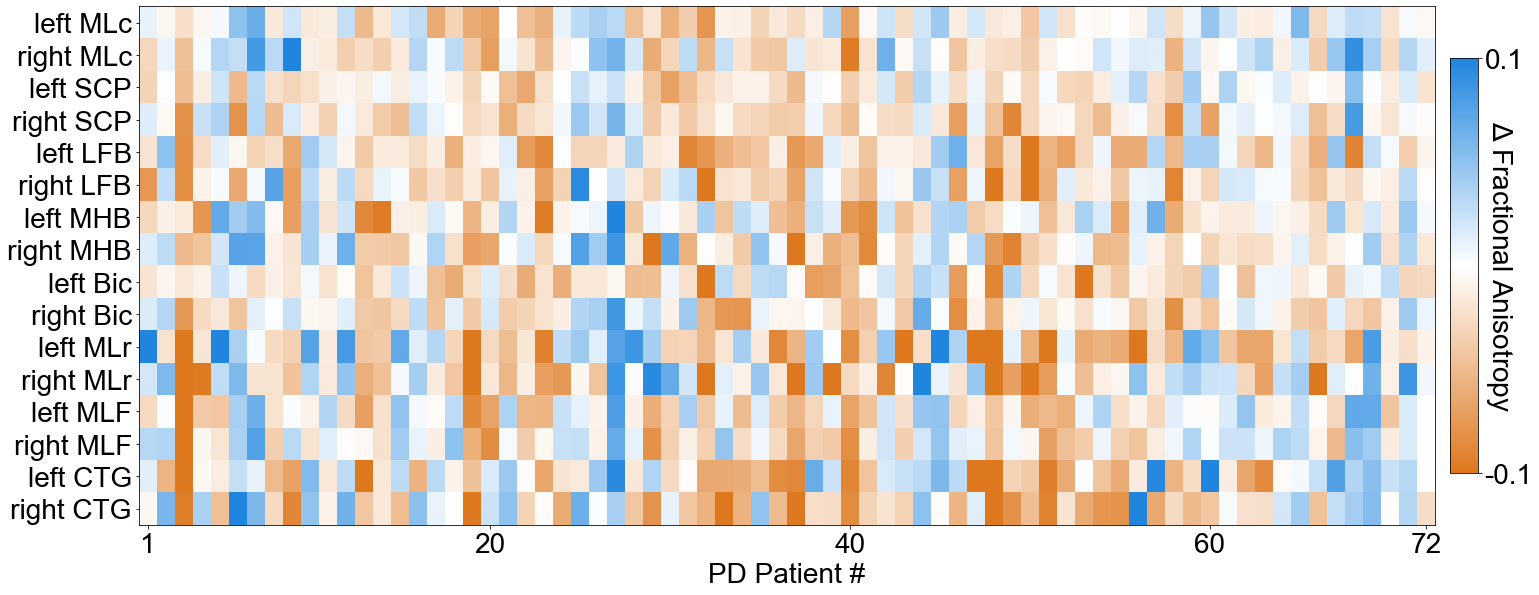

In [10]:
plt.rcParams['font.family'] = 'Arial'
#plt.rcParams['font.weight'] = 'bold'


difference_map = (patients_bsb_followup - patients_bsb).T


color_low = "#1F85DE"  # Color from patient violin plot
color_high = "#DE781F"  # blend 


cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", [color_high,'white',color_low])

vmin=-0.1
vmax=0.1
# Create the heatmap
fig = plt.figure(figsize=(60,12))

plot_area = [0.2, 0.2, 0.7, 0.6]
ax = fig.add_axes(plot_area)

plt.imshow(difference_map, cmap=cmap, interpolation='nearest',vmin=vmin, vmax=vmax, aspect=1.8)

#cbar.formatter = formatter
#cbar.update_ticks()


cbar = plt.colorbar(shrink=0.8,aspect=15, pad=0.005)
cbar.set_label(r'$\Delta$ Fractional Anisotropy', rotation=270, labelpad=-18, fontsize=28, fontweight='regular')
#cbar.ax.tick_params(labelsize=20)

# Set colorbar ticks at the top and bottom
cbar_min, cbar_max = vmin,vmax
cbar.set_ticks([cbar_min, cbar_max])
cbar.ax.tick_params(labelsize=28)
for t in cbar.ax.get_yticklabels():
    t.set_fontweight('normal')


cbar.set_ticklabels(["-0.1", "0.1"])


plt.yticks(ticks=np.arange(len(label_names)), labels=label_names, rotation=0,fontsize=28,fontweight='regular')
#plt.xticks(ticks=np.arange(len(case_list_patient)), labels=np.arange(len(case_list_patient)),fontsize=28,fontweight='regular')
plt.xticks(ticks=[0,19,39,59,71],labels=[1,20,40,60,72], fontsize=28, fontweight='regular')
plt.xlabel('PD Patient #', fontsize=28, fontweight='regular')



# Show the plot
plt.tight_layout() 
plt.savefig('/Users/markolchanyi/Desktop/BSB_Figs/PPMI_difference_heatmap.png', dpi=300)
plt.show()

<ipython-input-11-76fcbcdf046a>:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjusts subplot params so that the subplot(s) fits in to the figure area


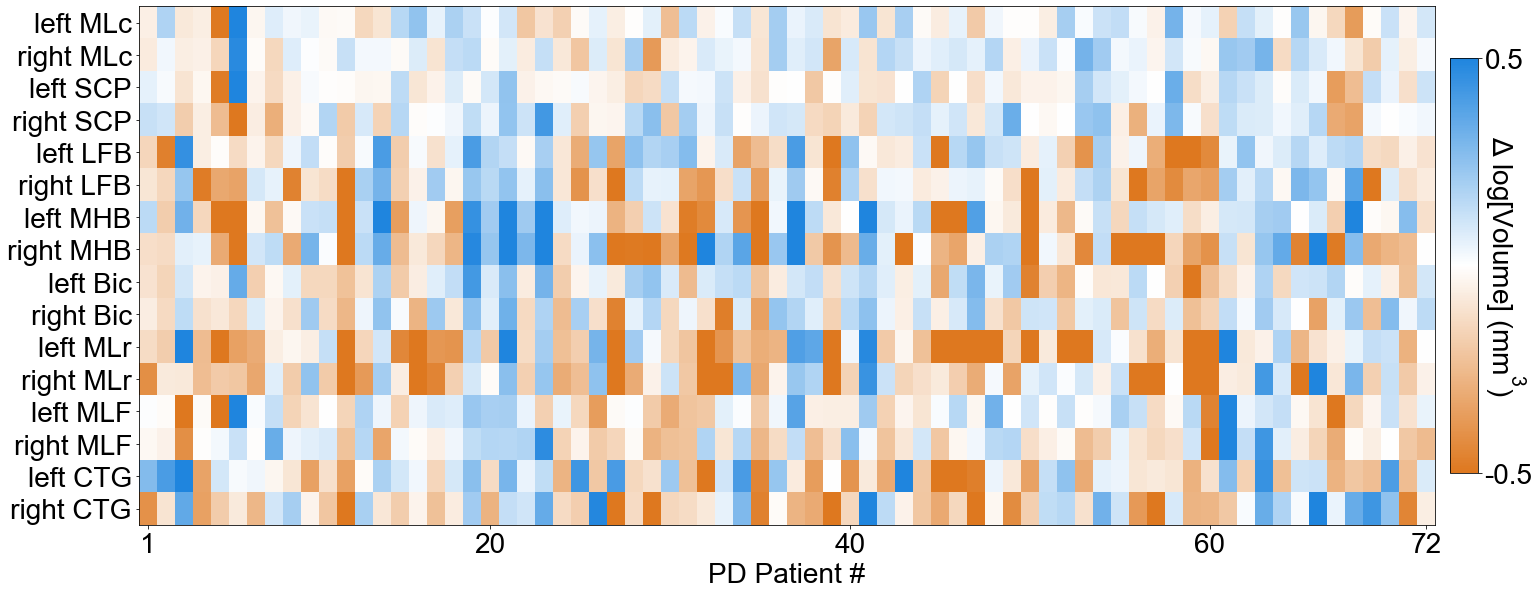

In [11]:
plt.rcParams['font.family'] = 'Arial'
#plt.rcParams['font.weight'] = 'bold'


difference_map = (np.log(patients_bsb_followup_volume) - np.log(patients_bsb_volume)).T



color_low = "#1F85DE"  # Color from patient violin plot
color_high = "#DE781F"  # blend 


cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", [color_high,'white',color_low])

vmin=-0.5
vmax=0.5

fig = plt.figure(figsize=(60,12))

plot_area = [0.2, 0.2, 0.7, 0.6]
ax = fig.add_axes(plot_area)

plt.imshow(difference_map, cmap=cmap, interpolation='nearest',vmin=vmin, vmax=vmax, aspect=1.8)

#cbar.formatter = formatter
#cbar.update_ticks()


cbar = plt.colorbar(shrink=0.8,aspect=15, pad=0.005)
cbar.set_label(r'$\Delta$ log$[Volume]$ $(mm^{3})$', rotation=270, labelpad=-5, fontsize=28, fontweight='regular')
#cbar.ax.tick_params(labelsize=20)


cbar_min, cbar_max = vmin,vmax
cbar.set_ticks([cbar_min, cbar_max])
cbar.ax.tick_params(labelsize=28)
for t in cbar.ax.get_yticklabels():
    t.set_fontweight('normal')


cbar.set_ticklabels(["-0.5", "0.5"])


plt.yticks(ticks=np.arange(len(label_names)), labels=label_names, rotation=0,fontsize=28,fontweight='regular')
#plt.xticks(ticks=np.arange(len(case_list_patient)), labels=np.arange(len(case_list_patient)),fontsize=28,fontweight='regular')
plt.xticks(ticks=[0,19,39,59,71],labels=[1,20,40,60,72], fontsize=28, fontweight='regular')
plt.xlabel('PD Patient #', fontsize=28, fontweight='regular')


plt.tight_layout()
plt.savefig('/Users/markolchanyi/Desktop/BSB_Figs/PPMI_volume_difference_heatmap.png', dpi=300)
plt.show()

In [12]:
'''
for case in case_list_control:
    dir_case = os.path.join(base_path_bsb_controls,case,'DTI_gated',list_base_subdirectories(os.path.join(base_path_bsb_controls,case,'DTI_gated'))[0])
    dir_tractseg = os.path.join(dir_case,'tractseg_outputs','bundle_segmentations')
    dir_vol = os.path.join(dir_case,"bsb_outputs_attention", DTI_volume_to_use + "_1mm.nii.gz")
    print("starting patient: ",case)
    if os.path.isfile(dir_vol):
        for tract in tractseg_volume_list:
            if os.path.isfile(dir_tractseg + "/" + tract + ".nii.gz") and not os.path.exists(dir_tractseg + "/" + tract + "_conformed.nii.gz"):
                os.system("mri_convert " + dir_tractseg + "/" + tract + ".nii.gz " + dir_tractseg + "/" + tract + "_conformed.nii.gz -rl " + dir_vol + " -rt nearest -odt float")
            elif os.path.exists(dir_tractseg + "/" + tract + "_conformed.nii.gz"):
                print("exists!")
                #os.system("mri_convert " + dir_tractseg + "/" + tract + ".nii.gz " + dir_tractseg + "/" + tract + "_conformed.nii.gz -rl " + dir_fa + " -rt nearest -odt float")
            else:
                print(dir_tractseg + "/" + tract + ".nii.gz does not exist")
            
    else:
        print("full FA does not exist!")
        
for case in case_list_patient:
    dir_case = os.path.join(base_path_bsb_patients,case,'DTI_gated',list_base_subdirectories(os.path.join(base_path_bsb_patients,case,'DTI_gated'))[0])
    dir_tractseg = os.path.join(dir_case,'tractseg_outputs','bundle_segmentations')
    dir_vol = os.path.join(dir_case,"bsb_outputs_attention",DTI_volume_to_use + "_1mm.nii.gz")
    print("starting patient: ",case)
    if os.path.isfile(dir_vol):
        for tract in tractseg_volume_list:
            if os.path.isfile(dir_tractseg + "/" + tract + ".nii.gz") and not os.path.exists(dir_tractseg + "/" + tract + "_conformed.nii.gz"):
                os.system("mri_convert " + dir_tractseg + "/" + tract + ".nii.gz " + dir_tractseg + "/" + tract + "_conformed.nii.gz -rl " + dir_vol + " -rt nearest -odt float")
            elif os.path.exists(dir_tractseg + "/" + tract + "_conformed.nii.gz"):
                print("exists!")
                #os.system("mri_convert " + dir_tractseg + "/" + tract + ".nii.gz " + dir_tractseg + "/" + tract + "_conformed.nii.gz -rl " + dir_fa + " -rt nearest -odt float")
            else:
                print(dir_tractseg + "/" + tract + ".nii.gz does not exist")
            
    else:
        print("full FA does not exist!")
        
for case in case_list_patient:
    dir_case = os.path.join(base_path_bsb_patients_followup,case,'DTI_gated',list_base_subdirectories(os.path.join(base_path_bsb_patients_followup,case,'DTI_gated'))[0])
    dir_tractseg = os.path.join(dir_case,'tractseg_outputs','bundle_segmentations')
    dir_vol = os.path.join(dir_case,"bsb_outputs_attention",DTI_volume_to_use + "_1mm.nii.gz")
    print("starting patient: ",case)
    if os.path.isfile(dir_vol):
        for tract in tractseg_volume_list:
            if os.path.isfile(dir_tractseg + "/" + tract + ".nii.gz") and not os.path.exists(dir_tractseg + "/" + tract + "_conformed.nii.gz"):
                os.system("mri_convert " + dir_tractseg + "/" + tract + ".nii.gz " + dir_tractseg + "/" + tract + "_conformed.nii.gz -rl " + dir_vol + " -rt nearest -odt float")
            elif os.path.exists(dir_tractseg + "/" + tract + "_conformed.nii.gz"):
                print("exists!")
                #os.system("mri_convert " + dir_tractseg + "/" + tract + ".nii.gz " + dir_tractseg + "/" + tract + "_conformed.nii.gz -rl " + dir_fa + " -rt nearest -odt float")
            else:
                print(dir_tractseg + "/" + tract + ".nii.gz does not exist")
            
    else:
        print("full FA does not exist!")
'''

'\nfor case in case_list_control:\n    dir_case = os.path.join(base_path_bsb_controls,case,\'DTI_gated\',list_base_subdirectories(os.path.join(base_path_bsb_controls,case,\'DTI_gated\'))[0])\n    dir_tractseg = os.path.join(dir_case,\'tractseg_outputs\',\'bundle_segmentations\')\n    dir_vol = os.path.join(dir_case,"bsb_outputs_attention", DTI_volume_to_use + "_1mm.nii.gz")\n    print("starting patient: ",case)\n    if os.path.isfile(dir_vol):\n        for tract in tractseg_volume_list:\n            if os.path.isfile(dir_tractseg + "/" + tract + ".nii.gz") and not os.path.exists(dir_tractseg + "/" + tract + "_conformed.nii.gz"):\n                os.system("mri_convert " + dir_tractseg + "/" + tract + ".nii.gz " + dir_tractseg + "/" + tract + "_conformed.nii.gz -rl " + dir_vol + " -rt nearest -odt float")\n            elif os.path.exists(dir_tractseg + "/" + tract + "_conformed.nii.gz"):\n                print("exists!")\n                #os.system("mri_convert " + dir_tractseg + "/" + 

In [13]:
case_list_control_pruned_tractseg = case_list_control
case_list_patient_pruned_tractseg = case_list_patient
case_list_patient_pruned_tractseg_followup = case_list_patient


print("length of pruned patient cases: ", len(case_list_patient_pruned_tractseg))
controls_bsb_tractseg = np.zeros((len(case_list_control_pruned_tractseg),len(tractseg_volume_list)))
patients_bsb_tractseg = np.zeros((len(case_list_patient_pruned_tractseg),len(tractseg_volume_list)))
patients_bsb_tractseg_followup = np.zeros((len(case_list_patient_pruned_tractseg_followup),len(tractseg_volume_list)))

controls_bsb_tractseg_volume = np.zeros((len(case_list_control_pruned_tractseg),len(tractseg_volume_list)))
patients_bsb_tractseg_volume = np.zeros((len(case_list_patient_pruned_tractseg),len(tractseg_volume_list)))
patients_bsb_tractseg_followup_volume = np.zeros((len(case_list_patient_pruned_tractseg_followup),len(tractseg_volume_list)))


counter = 0

for case in case_list_control_pruned_tractseg:
    print("starting control: ",case)
    dir_case = os.path.join(base_path_bsb_controls,case,'DTI_gated',list_base_subdirectories(os.path.join(base_path_bsb_controls,case,'DTI_gated'))[0])
    dir_tractseg = os.path.join(dir_case,'tractseg_outputs','bundle_segmentations')
    dir_vol = os.path.join(dir_case,"bsb_outputs_attention", DTI_volume_to_use + "_1mm.nii.gz")
    vol = nib.load(os.path.join(dir_vol))
    vol_np = vol.get_fdata()
    vol_np = gaussian_filter(vol_np, sigma=blur_sigma)
    
    samseg_vol = nib.load(os.path.join(dir_case,"bsb_outputs_attention","samseg_labels","seg.mgz"))
    samseg_vol_np = samseg_vol.get_fdata()
    
 
                      
    counter_tract = 0
    for tract in tractseg_volume_list:               
        tract_vol = nib.load(os.path.join(dir_tractseg,tract + "_conformed.nii.gz"))
        tract_vol_np = tract_vol.get_fdata()
                      
        tract_vol_np_thresholded = threshold_tract_vol_by_intensity(tract_vol_np,1)
        
        mean_diff = extract_mean_diff(vol_np,tract_vol_np_thresholded,erode_vol=False)
        volm = extract_volume(tract_vol_np_thresholded,erode_vol=False)
        controls_bsb_tractseg[counter,counter_tract] = mean_diff
        controls_bsb_tractseg_volume[counter,counter_tract] = volm
        counter_tract += 1
    counter += 1
    

counter = 0
for case in case_list_patient_pruned_tractseg:
    print("starting patient: ",case)
    dir_case = os.path.join(base_path_bsb_patients,case,'DTI_gated',list_base_subdirectories(os.path.join(base_path_bsb_patients,case,'DTI_gated'))[0])
    dir_tractseg = os.path.join(dir_case,'tractseg_outputs','bundle_segmentations')
    dir_vol = os.path.join(dir_case,"bsb_outputs_attention",DTI_volume_to_use + "_1mm.nii.gz")
    vol = nib.load(os.path.join(dir_vol))
    vol_np = vol.get_fdata()
    vol_np = gaussian_filter(vol_np, sigma=blur_sigma)
    
    samseg_vol = nib.load(os.path.join(dir_case,"bsb_outputs_attention","samseg_labels","seg.mgz"))
    samseg_vol_np = samseg_vol.get_fdata()
    
                      
    counter_tract = 0
    for tract in tractseg_volume_list:               
        tract_vol = nib.load(os.path.join(dir_tractseg,tract + "_conformed.nii.gz"))
        tract_vol_np = tract_vol.get_fdata()
                      
        tract_vol_np_thresholded = threshold_tract_vol_by_intensity(tract_vol_np,1)
        mean_diff = extract_mean_diff(vol_np,tract_vol_np_thresholded,erode_vol=False)
        volm = extract_volume(tract_vol_np_thresholded,erode_vol=False)
        patients_bsb_tractseg[counter,counter_tract] = mean_diff
        patients_bsb_tractseg_volume[counter,counter_tract] = volm
        counter_tract += 1
    counter += 1
print(" ")
counter = 0
for case in case_list_patient_pruned_tractseg_followup:
    print("starting patient: ",case)
    dir_case = os.path.join(base_path_bsb_patients_followup,case,'DTI_gated',list_base_subdirectories(os.path.join(base_path_bsb_patients_followup,case,'DTI_gated'))[0])
    dir_tractseg = os.path.join(dir_case,'tractseg_outputs','bundle_segmentations')
    dir_vol = os.path.join(dir_case,"bsb_outputs_attention",DTI_volume_to_use + "_1mm.nii.gz")
    vol = nib.load(os.path.join(dir_vol))
    vol_np = vol.get_fdata()
    vol_np = gaussian_filter(vol_np, sigma=blur_sigma)
    
    samseg_vol = nib.load(os.path.join(dir_case,"bsb_outputs_attention","samseg_labels","seg.mgz"))
    samseg_vol_np = samseg_vol.get_fdata()
    
                      
    counter_tract = 0
    for tract in tractseg_volume_list:               
        tract_vol = nib.load(os.path.join(dir_tractseg,tract + "_conformed.nii.gz"))
        tract_vol_np = tract_vol.get_fdata()
                      
        tract_vol_np_thresholded = threshold_tract_vol_by_intensity(tract_vol_np,1)
        mean_diff = extract_mean_diff(vol_np,tract_vol_np_thresholded,erode_vol=False)
        volm = extract_volume(tract_vol_np_thresholded,erode_vol=False)
        patients_bsb_tractseg_followup[counter,counter_tract] = mean_diff
        patients_bsb_tractseg_followup_volume[counter,counter_tract] = volm
        counter_tract += 1
    counter += 1



length of pruned patient cases:  72
starting control:  3106
starting control:  3109
starting control:  3112
starting control:  3114
starting control:  3115
starting control:  3157
starting control:  3160
starting control:  3165
starting control:  3169
starting control:  3171
starting control:  3172
starting control:  3188
starting control:  3191
starting control:  3300
starting control:  3370
starting control:  3389
starting control:  3390
starting control:  3554
starting control:  3555
starting control:  3563
starting control:  3569
starting control:  3570
starting control:  3571
starting control:  3572
starting control:  3756
starting control:  3759
starting control:  3765
starting control:  3767
starting control:  3768
starting control:  3769
starting control:  3779
starting control:  3803
starting control:  3804
starting control:  3805
starting control:  3806
starting control:  3807
starting control:  3809
starting control:  3811
starting control:  3812
starting control:  3813
star

num labels is:  15
IFO_left  c-p pval:  0.06604443724504384
IFO_left  p-pf pval:  0.00025337511602491154
IFO_left  c-pf pval:  0.7806260122619193
IFO_left  c-p pval CORRECTED:  0.17890344873846092
IFO_left  p-pf pval CORRECTED:  0.0007601253480747347
IFO_left  c-pf pval CORRECTED:  0.8363850131377707
 
IFO_right  c-p pval:  0.028704801173239126
IFO_right  p-pf pval:  0.0005353512228671467
IFO_right  c-pf pval:  0.48785376493480614
IFO_right  c-p pval CORRECTED:  0.17890344873846092
IFO_right  p-pf pval CORRECTED:  0.0012993848359640291
IFO_right  c-pf pval CORRECTED:  0.8298510776943707
 
OR_left  c-p pval:  0.12873504895794788
OR_left  p-pf pval:  0.09670114165439178
OR_left  c-pf pval:  0.3701062602946459
OR_left  c-p pval CORRECTED:  0.19162831283948994
OR_left  p-pf pval CORRECTED:  0.1036083660582769
OR_left  c-pf pval CORRECTED:  0.8298510776943707
 
OR_right  c-p pval:  0.011511203968628193
OR_right  p-pf pval:  0.022373926052204507
OR_right  c-pf pval:  0.09673502636993887
OR_r

<ipython-input-2-1e8f84595b11>:347: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


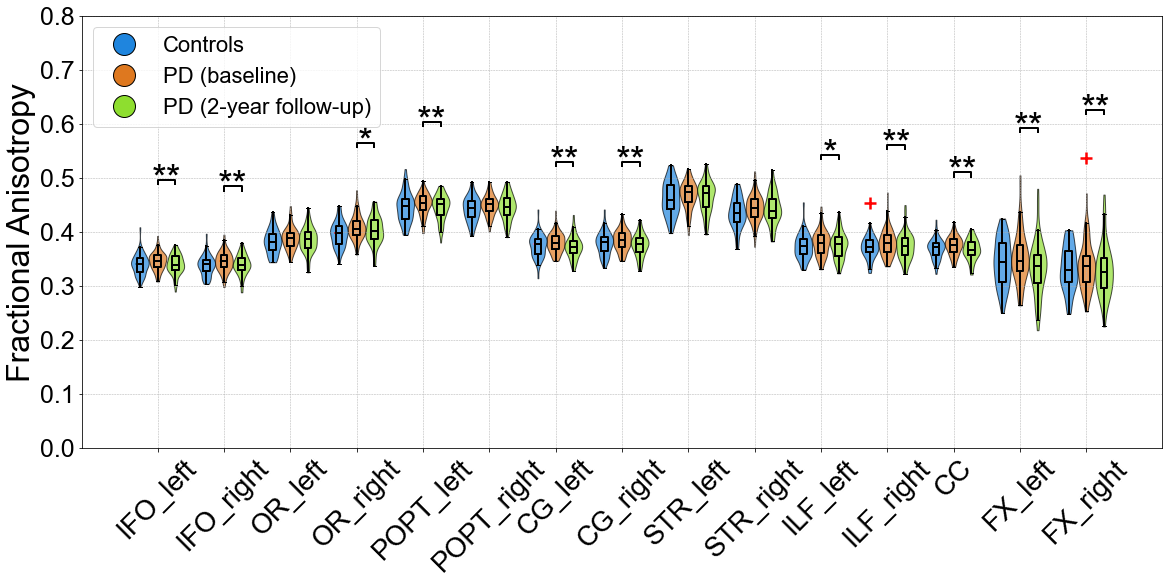

In [14]:
fig_save_path = '/Users/markolchanyi/Desktop/BSB_Figs/PPMI_violin_tractseg.png'
ylab_name= 'Fractional Anisotropy'
labels = tractseg_volume_list
y_lower = 0
y_upper = 0.8
figsize = (25, 10)
controls = controls_bsb_tractseg
patients = patients_bsb_tractseg
followup = patients_bsb_tractseg_followup


plot_differences(labels, controls, patients, followup, ylab_name, fig_save_path, y_lower, y_upper, figsize)

num labels is:  15
IFO_left  c-p pval:  0.02945150806136964
IFO_left  p-pf pval:  0.39056725212988164
IFO_left  c-pf pval:  0.051232965240719894
IFO_left  c-p pval CORRECTED:  0.29294795592020845
IFO_left  p-pf pval CORRECTED:  0.5858508781948225
IFO_left  c-pf pval CORRECTED:  0.349601263431648
 
IFO_right  c-p pval:  0.09572212691361114
IFO_right  p-pf pval:  0.07711383868776311
IFO_right  c-pf pval:  0.21662884501215451
IFO_right  c-p pval CORRECTED:  0.29294795592020845
IFO_right  p-pf pval CORRECTED:  0.18860676843049423
IFO_right  c-pf pval CORRECTED:  0.5146192594593163
 
OR_left  c-p pval:  0.06755036845063436
OR_left  p-pf pval:  0.5708629523576603
OR_left  c-pf pval:  0.06347567000152421
OR_left  c-p pval CORRECTED:  0.29294795592020845
OR_left  p-pf pval CORRECTED:  0.7135786904470753
OR_left  c-pf pval CORRECTED:  0.349601263431648
 
OR_right  c-p pval:  0.7135309859148334
OR_right  p-pf pval:  0.8267621866861048
OR_right  c-pf pval:  0.702232097404255
OR_right  c-p pval CO

<ipython-input-2-1e8f84595b11>:347: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


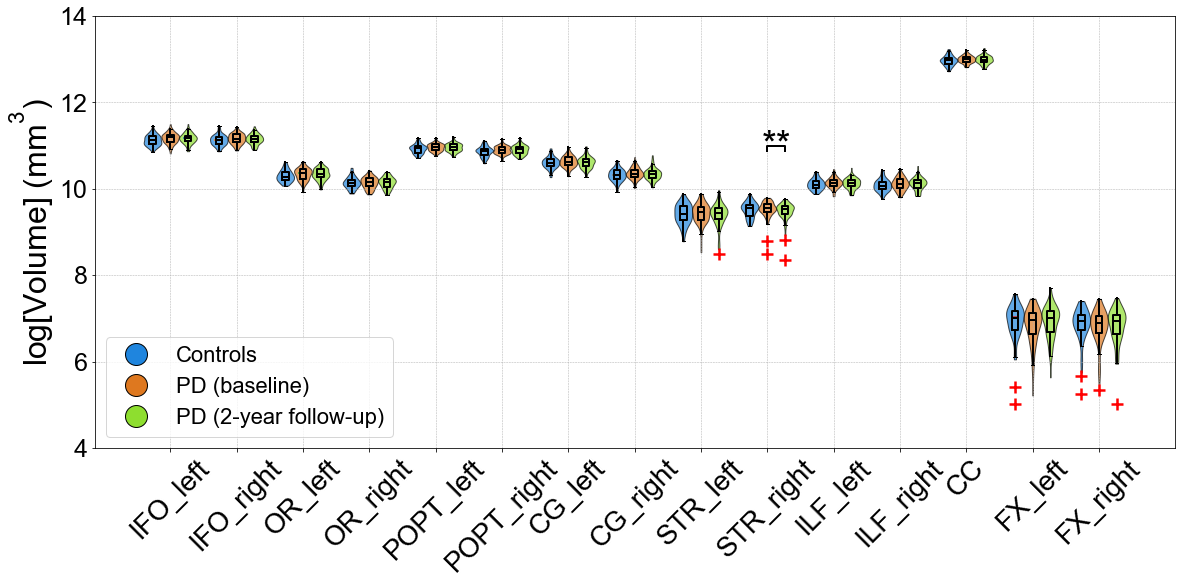

In [15]:
fig_save_path = '/Users/markolchanyi/Desktop/BSB_Figs/PPMI_violin_tractseg_volume.png'
ylab_name= r'log$[Volume]$ $(mm^{3})$'
labels = tractseg_volume_list
y_lower = 4
y_upper = 14
figsize = (25, 10)
controls = np.log(controls_bsb_tractseg_volume)
patients = np.log(patients_bsb_tractseg_volume)
followup = np.log(patients_bsb_tractseg_followup_volume)


plot_differences(labels, controls, patients, followup, ylab_name, fig_save_path, y_lower, y_upper, figsize)

In [77]:
###### for brainstem only!!! #######
case_list_control_pruned_brainstem = case_list_control
case_list_patient_pruned_brainstem = case_list_patient
case_list_patient_pruned_brainstem_followup = case_list_patient_followup


print("length of pruned patient cases: ", len(case_list_patient_pruned_brainstem))
controls_bsb_brainstem = np.zeros((len(case_list_control_pruned_brainstem),1))
patients_bsb_brainstem = np.zeros((len(case_list_patient_pruned_brainstem),1))
patients_bsb_brainstem_followup = np.zeros((len(case_list_patient_pruned_brainstem_followup),1))

controls_bsb_brainstem_volume = np.zeros((len(case_list_control_pruned_brainstem),1))
patients_bsb_brainstem_volume = np.zeros((len(case_list_patient_pruned_brainstem),1))
patients_bsb_brainstem_followup_volume = np.zeros((len(case_list_patient_pruned_brainstem_followup),1))


counter = 0
for case in case_list_control_pruned_brainstem:
    print("starting control: ",case)
    dir_case = os.path.join(base_path_bsb_controls,case,'DTI_gated',list_base_subdirectories(os.path.join(base_path_bsb_controls,case,'DTI_gated'))[0])
    dir_seg = os.path.join(dir_case,'bsb_outputs_attention','samseg_labels',"seg.mgz")
    dir_vol = os.path.join(dir_case,"bsb_outputs_attention", DTI_volume_to_use + "_1mm.nii.gz")
    vol = nib.load(os.path.join(dir_vol))
    vol_np = vol.get_fdata()
    seg_vol = nib.load(os.path.join(dir_seg))
    seg_vol_np = seg_vol.get_fdata()
    vol_np = gaussian_filter(vol_np, sigma=blur_sigma)
    
    seg_vol_np_thresholded = threshold_tract_vol_by_intensity(seg_vol_np,16)
                      
    mean_diff = extract_mean_diff(vol_np,seg_vol_np_thresholded,erode_vol=True)
    volm = extract_volume(seg_vol_np_thresholded,erode_vol=True)
    controls_bsb_brainstem[counter,0] = mean_diff
    controls_bsb_brainstem_volume[counter,0] = volm
    counter += 1
    
    

counter = 0
for case in case_list_patient_pruned_brainstem:
    print("starting patient: ",case)
    dir_case = os.path.join(base_path_bsb_patients,case,'DTI_gated',list_base_subdirectories(os.path.join(base_path_bsb_patients,case,'DTI_gated'))[0])
    dir_seg = os.path.join(dir_case,'bsb_outputs_attention','samseg_labels',"seg.mgz")
    dir_vol = os.path.join(dir_case,"bsb_outputs_attention", DTI_volume_to_use + "_1mm.nii.gz")
    vol = nib.load(os.path.join(dir_vol))
    vol_np = vol.get_fdata()
    seg_vol = nib.load(os.path.join(dir_seg))
    seg_vol_np = seg_vol.get_fdata()
    vol_np = gaussian_filter(vol_np, sigma=blur_sigma)
    
    ## brainstem aseg label: 16
    seg_vol_np_thresholded = threshold_tract_vol_by_intensity(seg_vol_np,16)
                    
    mean_diff = extract_mean_diff(vol_np,seg_vol_np_thresholded,erode_vol=True)
    volm = extract_volume(seg_vol_np_thresholded,erode_vol=True)
    patients_bsb_brainstem[counter,0] = mean_diff
    patients_bsb_brainstem_volume[counter,0] = volm
    counter += 1
    
counter = 0
for case in case_list_patient_pruned_brainstem_followup:
    print("starting patient: ",case)
    dir_case = os.path.join(base_path_bsb_patients_followup,case,'DTI_gated',list_base_subdirectories(os.path.join(base_path_bsb_patients_followup,case,'DTI_gated'))[0])
    dir_seg = os.path.join(dir_case,'bsb_outputs_attention','samseg_labels',"seg.mgz")
    dir_vol = os.path.join(dir_case,"bsb_outputs_attention", DTI_volume_to_use + "_1mm.nii.gz")
    vol = nib.load(os.path.join(dir_vol))
    vol_np = vol.get_fdata()
    seg_vol = nib.load(os.path.join(dir_seg))
    seg_vol_np = seg_vol.get_fdata()
    vol_np = gaussian_filter(vol_np, sigma=blur_sigma)
    
    ## brainstem aseg label
    seg_vol_np_thresholded = threshold_tract_vol_by_intensity(seg_vol_np,16)
                      
    mean_diff = extract_mean_diff(vol_np,seg_vol_np_thresholded,erode_vol=True)
    volm = extract_volume(seg_vol_np_thresholded,erode_vol=True)
    patients_bsb_brainstem_followup[counter,0] = mean_diff
    patients_bsb_brainstem_followup_volume[counter,0] = volm
    counter += 1


length of pruned patient cases:  72
starting control:  3106
starting control:  3109
starting control:  3112
starting control:  3114
starting control:  3115
starting control:  3157
starting control:  3160
starting control:  3165
starting control:  3169
starting control:  3171
starting control:  3172
starting control:  3188
starting control:  3191
starting control:  3300
starting control:  3370
starting control:  3389
starting control:  3390
starting control:  3554
starting control:  3555
starting control:  3563
starting control:  3569
starting control:  3570
starting control:  3571
starting control:  3572
starting control:  3756
starting control:  3759
starting control:  3765
starting control:  3767
starting control:  3768
starting control:  3769
starting control:  3779
starting control:  3803
starting control:  3804
starting control:  3805
starting control:  3806
starting control:  3807
starting control:  3809
starting control:  3811
starting control:  3812
starting control:  3813
star

num labels is:  1
Whole Brainstem  c-p pval:  0.3234363510452939
Whole Brainstem  p-pf pval:  1.266018233391234e-05
Whole Brainstem  c-pf pval:  0.12495583104424379
Whole Brainstem  c-p pval CORRECTED:  0.3234363510452939
Whole Brainstem  p-pf pval CORRECTED:  1.266018233391234e-05
Whole Brainstem  c-pf pval CORRECTED:  0.12495583104424379
 


<ipython-input-63-015304147f6b>:347: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


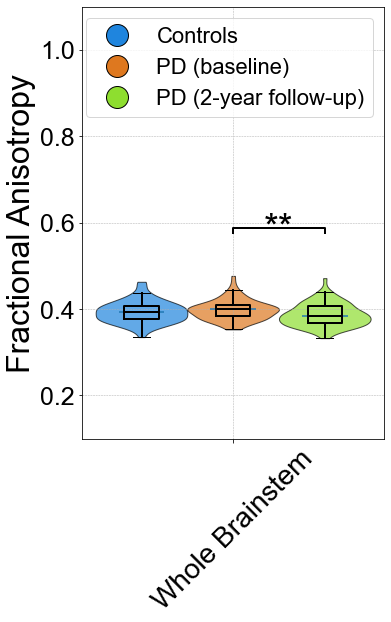

In [78]:
fig_save_path = '/Users/markolchanyi/Desktop/BSB_Figs/PPMI_violin_BRAINSTEM.png'
ylab_name= 'Fractional Anisotropy'
labels = ["Whole Brainstem"]
y_lower = 0.1
y_upper = 1.1
figsize = (7, 10)
controls = controls_bsb_brainstem
patients = patients_bsb_brainstem
followup = patients_bsb_brainstem_followup


plot_differences(labels,controls,patients,followup,ylab_name,fig_save_path,y_lower,y_upper,figsize)

num labels is:  1
Whole Brainstem  c-p pval:  0.25351070580590696
Whole Brainstem  p-pf pval:  0.26411106830552245
Whole Brainstem  c-pf pval:  0.5006472603732319
Whole Brainstem  c-p pval CORRECTED:  0.25351070580590696
Whole Brainstem  p-pf pval CORRECTED:  0.26411106830552245
Whole Brainstem  c-pf pval CORRECTED:  0.5006472603732319
 


<ipython-input-63-015304147f6b>:347: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


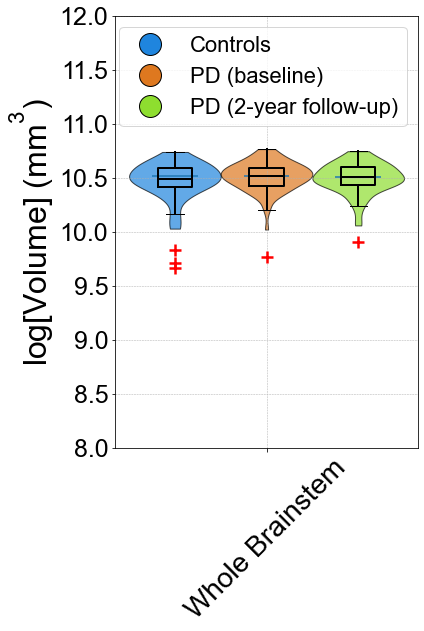

In [88]:
fig_save_path = '/Users/markolchanyi/Desktop/BSB_Figs/PPMI_violin_BRAINSTEM_volume.png'
ylab_name= r'log$[Volume]$ $(mm^{3})$'
labels = ["Whole Brainstem"]
y_lower = 8
y_upper = 12
figsize = (7, 10)
controls = np.log(controls_bsb_brainstem_volume)
patients = np.log(patients_bsb_brainstem_volume)
followup = np.log(patients_bsb_brainstem_followup_volume)


plot_differences(labels,controls,patients,followup,ylab_name,fig_save_path,y_lower,y_upper,figsize)

In [19]:
### FOR CORTICAL WHITE MATTER
case_list_control_pruned_cwm = case_list_control
case_list_patient_pruned_cwm = case_list_patient
case_list_patient_pruned_cwm_followup = case_list_patient


print("length of pruned patient cases: ", len(case_list_patient_pruned_cwm))
controls_bsb_cwm = np.zeros((len(case_list_control_pruned_cwm),len(cwm_volume_list)))
patients_bsb_cwm = np.zeros((len(case_list_patient_pruned_cwm),len(cwm_volume_list)))
patients_bsb_cwm_followup = np.zeros((len(case_list_patient_pruned_cwm_followup),len(cwm_volume_list)))

controls_bsb_cwm_volume = np.zeros((len(case_list_control_pruned_cwm),len(cwm_volume_list)))
patients_bsb_cwm_volume = np.zeros((len(case_list_patient_pruned_cwm),len(cwm_volume_list)))
patients_bsb_cwm_followup_volume = np.zeros((len(case_list_patient_pruned_cwm_followup),len(cwm_volume_list)))



counter = 0
for case in case_list_patient_pruned_cwm:
    print("starting patient: ",case)
    dir_case = os.path.join(base_path_bsb_patients,case,'DTI_gated',list_base_subdirectories(os.path.join(base_path_bsb_patients,case,'DTI_gated'))[0])
    dir_seg = os.path.join(dir_case,'bsb_outputs_attention','samseg_labels',"seg.mgz")
    dir_vol = os.path.join(dir_case,"bsb_outputs_attention", DTI_volume_to_use + "_1mm.nii.gz")
    vol = nib.load(os.path.join(dir_vol))
    vol_np = vol.get_fdata()
    vol_np = gaussian_filter(vol_np, sigma=blur_sigma)
    seg_vol = nib.load(os.path.join(dir_seg))
    seg_vol_np = seg_vol.get_fdata()
    
    
    seg_vol_np_thresholded_left = threshold_tract_vol_by_intensity(seg_vol_np,3)

    mean_diff_left = extract_mean_diff(vol_np,seg_vol_np_thresholded_left,erode_vol=False)
    volm = extract_volume(seg_vol_np_thresholded_left,erode_vol=False)
    patients_bsb_cwm[counter,0] = mean_diff_left
    patients_bsb_cwm_volume[counter,0] = volm

    seg_vol_np_thresholded_right = threshold_tract_vol_by_intensity(seg_vol_np,42)                   
    mean_diff_right = extract_mean_diff(vol_np,seg_vol_np_thresholded_right,erode_vol=False)
    volm = extract_volume(seg_vol_np_thresholded_right,erode_vol=False)
    patients_bsb_cwm[counter,1] = mean_diff_right
    patients_bsb_cwm_volume[counter,1] = volm
    
    counter += 1



counter = 0
for case in case_list_control_pruned_cwm:
    print("starting control: ",case)
    dir_case = os.path.join(base_path_bsb_controls,case,'DTI_gated',list_base_subdirectories(os.path.join(base_path_bsb_controls,case,'DTI_gated'))[0])
    dir_seg = os.path.join(dir_case,'bsb_outputs_attention','samseg_labels',"seg.mgz")
    dir_vol = os.path.join(dir_case,"bsb_outputs_attention", DTI_volume_to_use + "_1mm.nii.gz")
    vol = nib.load(os.path.join(dir_vol))
    vol_np = vol.get_fdata()
    vol_np = gaussian_filter(vol_np, sigma=blur_sigma)
    seg_vol = nib.load(os.path.join(dir_seg))
    seg_vol_np = seg_vol.get_fdata()
    
    seg_vol_np_thresholded_left = threshold_tract_vol_by_intensity(seg_vol_np,3)
    mean_diff_left = extract_mean_diff(vol_np,seg_vol_np_thresholded_left,erode_vol=False)
    volm = extract_volume(seg_vol_np_thresholded_left,erode_vol=False)
    controls_bsb_cwm[counter,0] = mean_diff_left
    controls_bsb_cwm_volume[counter,0] = volm

    seg_vol_np_thresholded_right = threshold_tract_vol_by_intensity(seg_vol_np,42)                   
    mean_diff_right = extract_mean_diff(vol_np,seg_vol_np_thresholded_right,erode_vol=False)
    volm = extract_volume(seg_vol_np_thresholded_right,erode_vol=False)
    controls_bsb_cwm[counter,1] = mean_diff_right
    controls_bsb_cwm_volume[counter,1] = volm
    
    counter += 1
    

counter = 0
for case in case_list_patient_pruned_cwm_followup:
    print("starting patient: ",case)
    dir_case = os.path.join(base_path_bsb_patients_followup,case,'DTI_gated',list_base_subdirectories(os.path.join(base_path_bsb_patients_followup,case,'DTI_gated'))[0])
    dir_seg = os.path.join(dir_case,'bsb_outputs_attention','samseg_labels',"seg.mgz")
    dir_vol = os.path.join(dir_case,"bsb_outputs_attention", DTI_volume_to_use + "_1mm.nii.gz")
    vol = nib.load(os.path.join(dir_vol))
    vol_np = vol.get_fdata()
    vol_np = gaussian_filter(vol_np, sigma=blur_sigma)
    seg_vol = nib.load(os.path.join(dir_seg))
    seg_vol_np = seg_vol.get_fdata()
    
    
    seg_vol_np_thresholded_left = threshold_tract_vol_by_intensity(seg_vol_np,3)

    mean_diff_left = extract_mean_diff(vol_np,seg_vol_np_thresholded_left,erode_vol=False)
    volm = extract_volume(seg_vol_np_thresholded_left,erode_vol=False)
    patients_bsb_cwm_followup[counter,0] = mean_diff_left
    patients_bsb_cwm_followup_volume[counter,0] = volm
    
    seg_vol_np_thresholded_right = threshold_tract_vol_by_intensity(seg_vol_np,42)                   
    mean_diff_right = extract_mean_diff(vol_np,seg_vol_np_thresholded_right,erode_vol=False)
    volm = extract_volume(seg_vol_np_thresholded_right,erode_vol=False)
    patients_bsb_cwm_followup[counter,1] = mean_diff_right
    patients_bsb_cwm_followup_volume[counter,1] = volm
    
    counter += 1


length of pruned patient cases:  72
starting patient:  3107
starting patient:  3108
starting patient:  3111
starting patient:  3120
starting patient:  3124
starting patient:  3126
starting patient:  3128
starting patient:  3131
starting patient:  3132
starting patient:  3150
starting patient:  3154
starting patient:  3168
starting patient:  3173
starting patient:  3174
starting patient:  3175
starting patient:  3179
starting patient:  3181
starting patient:  3182
starting patient:  3184
starting patient:  3185
starting patient:  3373
starting patient:  3377
starting patient:  3564
starting patient:  3567
starting patient:  3574
starting patient:  3575
starting patient:  3585
starting patient:  3587
starting patient:  3588
starting patient:  3591
starting patient:  3752
starting patient:  3757
starting patient:  3758
starting patient:  3760
starting patient:  3762
starting patient:  3770
starting patient:  3771
starting patient:  3775
starting patient:  3777
starting patient:  3778
star

num labels is:  2
left Hemispheric GM  c-p pval:  0.278528385751322
left Hemispheric GM  p-pf pval:  5.341720999773529e-09
left Hemispheric GM  c-pf pval:  0.007503475581556585
left Hemispheric GM  c-p pval CORRECTED:  0.278528385751322
left Hemispheric GM  p-pf pval CORRECTED:  8.252938896239018e-09
left Hemispheric GM  c-pf pval CORRECTED:  0.010707479621232094
 
right Hemispheric GM  c-p pval:  0.1731554584115027
right Hemispheric GM  p-pf pval:  8.252938896239018e-09
right Hemispheric GM  c-pf pval:  0.010707479621232094
right Hemispheric GM  c-p pval CORRECTED:  0.278528385751322
right Hemispheric GM  p-pf pval CORRECTED:  8.252938896239018e-09
right Hemispheric GM  c-pf pval CORRECTED:  0.010707479621232094
 


<ipython-input-2-1e8f84595b11>:347: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


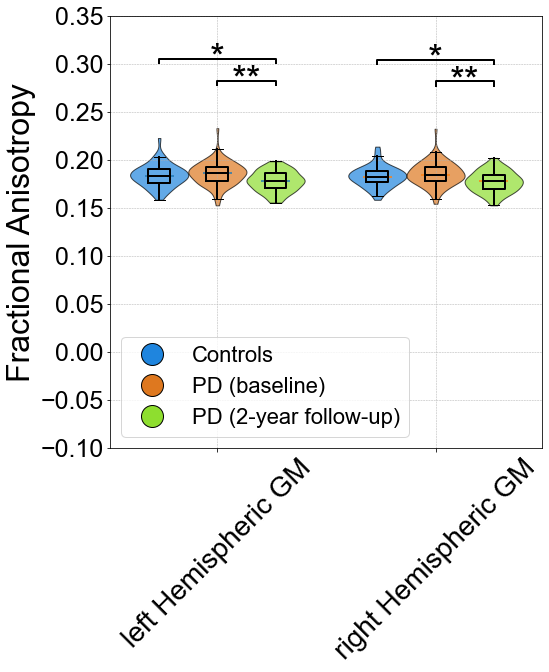

In [20]:
fig_save_path = '/Users/markolchanyi/Desktop/BSB_Figs/PPMI_violin_CWM.png'
ylab_name= 'Fractional Anisotropy'
labels = ["left Hemispheric GM", "right Hemispheric GM"]
y_lower = -0.1
y_upper = 0.35
figsize = (10, 10)
controls = controls_bsb_cwm
patients = patients_bsb_cwm
followup = patients_bsb_cwm_followup

plot_differences(labels,controls,patients,followup,ylab_name,fig_save_path,y_lower,y_upper,figsize)

num labels is:  2
left Hemispheric GM  c-p pval:  0.05496647916091242
left Hemispheric GM  p-pf pval:  0.26411106830552245
left Hemispheric GM  c-pf pval:  0.052453150855050375
left Hemispheric GM  c-p pval CORRECTED:  0.056916695025297705
left Hemispheric GM  p-pf pval CORRECTED:  0.26411106830552245
left Hemispheric GM  c-pf pval CORRECTED:  0.07976708398015708
 
right Hemispheric GM  c-p pval:  0.056916695025297705
right Hemispheric GM  p-pf pval:  0.005286916126535325
right Hemispheric GM  c-pf pval:  0.07976708398015708
right Hemispheric GM  c-p pval CORRECTED:  0.056916695025297705
right Hemispheric GM  p-pf pval CORRECTED:  0.01057383225307065
right Hemispheric GM  c-pf pval CORRECTED:  0.07976708398015708
 


<ipython-input-2-1e8f84595b11>:347: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


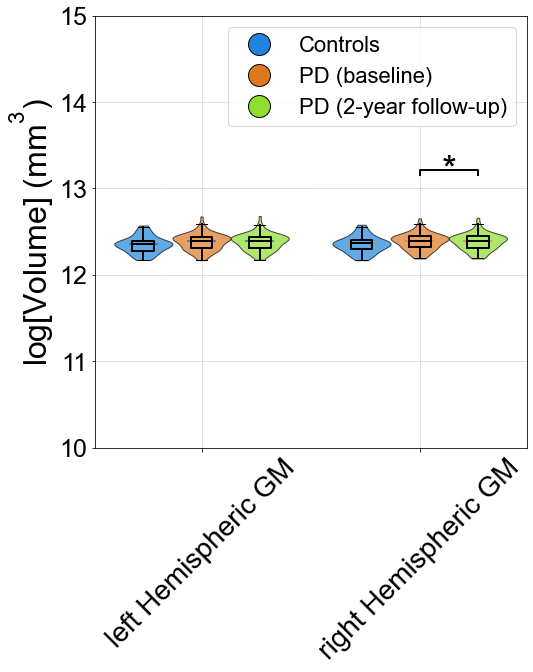

In [21]:
fig_save_path = '/Users/markolchanyi/Desktop/BSB_Figs/PPMI_violin_CWM_volume.png'
ylab_name= r'log$[Volume]$ $(mm^{3})$'
labels = ["left Hemispheric GM", "right Hemispheric GM"]
y_lower = 10
y_upper = 15
figsize = (10, 10)
controls = np.log(controls_bsb_cwm_volume)
patients = np.log(patients_bsb_cwm_volume)
followup = np.log(patients_bsb_cwm_followup_volume)


plot_differences(labels,controls,patients,followup,ylab_name,fig_save_path,y_lower,y_upper,figsize)

In [89]:
C=''
penalty=''
sol=''

scaler = StandardScaler()  # normalize the data for classification, only needed for multiple feats (not brainstem)

####################### for FA ##########################

###### BSB #######
all_y_test_cp, all_y_scores_cp, fpr_cp, tpr_cp, roc_auc_cp = roc(controls_bsb, 
                                                              patients_bsb, 
                                                              scaler=scaler,
                                                              flip_preds=False,
                                                              C=C, 
                                                              penalty=penalty, 
                                                              solver=sol)


all_y_test_cpf, all_y_scores_cpf, fpr_cpf, tpr_cpf, roc_auc_cpf = roc(controls_bsb, 
                                                              patients_bsb_followup, 
                                                              scaler=scaler,
                                                              flip_preds=False,
                                                              C=C, 
                                                              penalty=penalty, 
                                                              solver=sol)


all_y_test_ppf, all_y_scores_ppf, fpr_ppf, tpr_ppf, roc_auc_ppf = roc(patients_bsb, 
                                                              patients_bsb_followup, 
                                                              scaler=scaler,
                                                              flip_preds=False,
                                                              C=C, 
                                                              penalty=penalty, 
                                                              solver=sol)

###### Tractseg #######
all_y_test_tractseg_cp, all_y_scores_tractseg_cp, fpr_tractseg_cp, tpr_tractseg_cp, roc_auc_tractseg_cp = roc(controls_bsb_tractseg, 
                                                                                                              patients_bsb_tractseg, 
                                                                                                              scaler=scaler,
                                                                                                              flip_preds=True,
                                                                                                              C=C, 
                                                                                                              penalty=penalty, 
                                                                                                              solver=sol)

all_y_test_tractseg_cpf, all_y_scores_tractseg_cpf, fpr_tractseg_cpf, tpr_tractseg_cpf, roc_auc_tractseg_cpf = roc(controls_bsb_tractseg, 
                                                                                                              patients_bsb_tractseg_followup, 
                                                                                                              scaler=scaler,
                                                                                                              flip_preds=False,
                                                                                                              C=C, 
                                                                                                              penalty=penalty, 
                                                                                                              solver=sol)

all_y_test_tractseg_ppf, all_y_scores_tractseg_ppf, fpr_tractseg_ppf, tpr_tractseg_ppf, roc_auc_tractseg_ppf = roc(patients_bsb_tractseg, 
                                                                                                              patients_bsb_tractseg_followup, 
                                                                                                              scaler=scaler,
                                                                                                              flip_preds=False,
                                                                                                              C=C, 
                                                                                                              penalty=penalty, 
                                                                                                              solver=sol)
###### brainstem #######
# single feature so no scaling
all_y_test_brainstem_cp, all_y_scores_brainstem_cp, fpr_brainstem_cp, tpr_brainstem_cp, roc_auc_brainstem_cp = roc(controls_bsb_brainstem, 
                                                                                                                   patients_bsb_brainstem, 
                                                                                                                   scaler=scaler,
                                                                                                                   flip_preds=False,
                                                                                                                   C=C, 
                                                                                                                   penalty=penalty, 
                                                                                                                   solver=sol)

all_y_test_brainstem_cpf, all_y_scores_brainstem_cpf, fpr_brainstem_cpf, tpr_brainstem_cpf, roc_auc_brainstem_cpf = roc(controls_bsb_brainstem, 
                                                                                                                   patients_bsb_brainstem_followup, 
                                                                                                                   scaler=scaler,
                                                                                                                   flip_preds=False,
                                                                                                                   C=C, 
                                                                                                                   penalty=penalty, 
                                                                                                                   solver=sol)

all_y_test_brainstem_ppf, all_y_scores_brainstem_ppf, fpr_brainstem_ppf, tpr_brainstem_ppf, roc_auc_brainstem_ppf = roc(patients_bsb_brainstem, 
                                                                                                                   patients_bsb_brainstem_followup, 
                                                                                                                   scaler=scaler,
                                                                                                                   flip_preds=False,
                                                                                                                   C=C, 
                                                                                                                   penalty=penalty, 
                                                                                                                   solver=sol)

###### GM #######
all_y_test_cwm_cp, all_y_scores_cwm_cp, fpr_cwm_cp, tpr_cwm_cp, roc_auc_cwm_cp = roc(controls_bsb_cwm, 
                                                                                      patients_bsb_cwm, 
                                                                                      scaler=scaler,
                                                                                      flip_preds=False,
                                                                                      C=C, 
                                                                                      penalty=penalty, 
                                                                                      solver=sol)

all_y_test_cwm_cpf, all_y_scores_cwm_cpf, fpr_cwm_cpf, tpr_cwm_cpf, roc_auc_cwm_cpf = roc(controls_bsb_cwm, 
                                                                                      patients_bsb_cwm_followup, 
                                                                                      scaler=scaler,
                                                                                      flip_preds=False,
                                                                                      C=C, 
                                                                                      penalty=penalty, 
                                                                                      solver=sol)

all_y_test_cwm_ppf, all_y_scores_cwm_ppf, fpr_cwm_ppf, tpr_cwm_ppf, roc_auc_cwm_ppf = roc(patients_bsb_cwm, 
                                                                                      patients_bsb_cwm_followup, 
                                                                                      scaler=scaler,
                                                                                      flip_preds=False,
                                                                                      C=C, 
                                                                                      penalty=penalty, 
                                                                                      solver=sol)


####################### for volumes ##########################

###### BSB #######
all_y_test_cp_volume, all_y_scores_cp_volume, fpr_cp_volume, tpr_cp_volume, roc_auc_cp_volume = roc(controls_bsb_volume, 
                                                                                                  patients_bsb_volume, 
                                                                                                  scaler=scaler,
                                                                                                  flip_preds=False,
                                                                                                  C=C, 
                                                                                                  penalty=penalty, 
                                                                                                  solver=sol)


all_y_test_cpf_volume, all_y_scores_cpf_volume, fpr_cpf_volume, tpr_cpf_volume, roc_auc_cpf_volume = roc(controls_bsb_volume, 
                                                                                                      patients_bsb_followup_volume, 
                                                                                                      scaler=scaler,
                                                                                                      flip_preds=False,
                                                                                                      C=C, 
                                                                                                      penalty=penalty, 
                                                                                                      solver=sol)

all_y_test_ppf_volume, all_y_scores_ppf_volume, fpr_ppf_volume, tpr_ppf_volume, roc_auc_ppf_volume = roc(patients_bsb_volume, 
                                                                                                      patients_bsb_followup_volume, 
                                                                                                      scaler=scaler,
                                                                                                      flip_preds=False,
                                                                                                      C=C, 
                                                                                                      penalty=penalty, 
                                                                                                      solver=sol)

###### Tractseg #######
all_y_test_tractseg_cp_volume, all_y_scores_tractseg_cp_volume, fpr_tractseg_cp_volume, tpr_tractseg_cp_volume, roc_auc_tractseg_cp_volume = roc(controls_bsb_tractseg_volume, 
                                                                                                                                                  patients_bsb_tractseg_volume, 
                                                                                                                                                  scaler=scaler,
                                                                                                                                                  flip_preds=False,
                                                                                                                                                  C=C, 
                                                                                                                                                  penalty=penalty, 
                                                                                                                                                  solver=sol)

all_y_test_tractseg_cpf_volume, all_y_scores_tractseg_cpf_volume, fpr_tractseg_cpf_volume, tpr_tractseg_cpf_volume, roc_auc_tractseg_cpf_volume = roc(controls_bsb_tractseg_volume, 
                                                                                                                                                      patients_bsb_tractseg_followup_volume, 
                                                                                                                                                      scaler=scaler,
                                                                                                                                                      flip_preds=False,
                                                                                                                                                      C=C, 
                                                                                                                                                      penalty=penalty, 
                                                                                                                                                      solver=sol)

all_y_test_tractseg_ppf_volume, all_y_scores_tractseg_ppf_volume, fpr_tractseg_ppf_volume, tpr_tractseg_ppf_volume, roc_auc_tractseg_ppf_volume = roc(patients_bsb_tractseg_volume, 
                                                                                                                                                      patients_bsb_tractseg_followup_volume, 
                                                                                                                                                      scaler=scaler,
                                                                                                                                                      flip_preds=False,
                                                                                                                                                      C=C, 
                                                                                                                                                      penalty=penalty, 
                                                                                                                                                      solver=sol)
###### brainstem #######
# single feature so no scaling
all_y_test_brainstem_cp_volume, all_y_scores_brainstem_cp_volume, fpr_brainstem_cp_volume, tpr_brainstem_cp_volume, roc_auc_brainstem_cp_volume = roc(controls_bsb_brainstem_volume, 
                                                                                                                                                       patients_bsb_brainstem_volume, 
                                                                                                                                                       scaler=scaler,
                                                                                                                                                       flip_preds=False,
                                                                                                                                                       C=C, 
                                                                                                                                                       penalty=penalty, 
                                                                                                                                                       solver=sol)

all_y_test_brainstem_cpf_volume, all_y_scores_brainstem_cpf_volume, fpr_brainstem_cpf_volume, tpr_brainstem_cpf_volume, roc_auc_brainstem_cpf_volume = roc(controls_bsb_brainstem_volume, 
                                                                                                                                                       patients_bsb_brainstem_followup_volume, 
                                                                                                                                                       scaler=scaler,
                                                                                                                                                       flip_preds=False,
                                                                                                                                                       C=C, 
                                                                                                                                                       penalty=penalty, 
                                                                                                                                                       solver=sol)

all_y_test_brainstem_ppf_volume, all_y_scores_brainstem_ppf_volume, fpr_brainstem_ppf_volume, tpr_brainstem_ppf_volume, roc_auc_brainstem_ppf_volume = roc(patients_bsb_brainstem_volume, 
                                                                                                                                                       patients_bsb_brainstem_followup_volume, 
                                                                                                                                                       scaler=scaler,
                                                                                                                                                       flip_preds=True,
                                                                                                                                                       C=C, 
                                                                                                                                                       penalty=penalty, 
                                                                                                                                                       solver=sol)

###### GM #######
all_y_test_cwm_cp_volume, all_y_scores_cwm_cp_volume, fpr_cwm_cp_volume, tpr_cwm_cp_volume, roc_auc_cwm_cp_volume = roc(controls_bsb_cwm_volume, 
                                                                                                                          patients_bsb_cwm_volume, 
                                                                                                                          scaler=scaler,
                                                                                                                          flip_preds=False,
                                                                                                                          C=C, 
                                                                                                                          penalty=penalty, 
                                                                                                                          solver=sol)

all_y_test_cwm_cpf_volume, all_y_scores_cwm_cpf_volume, fpr_cwm_cpf_volume, tpr_cwm_cpf_volume, roc_auc_cwm_cpf_volume = roc(controls_bsb_cwm_volume, 
                                                                                                                          patients_bsb_cwm_followup_volume, 
                                                                                                                          scaler=scaler,
                                                                                                                          flip_preds=False,
                                                                                                                          C=C, 
                                                                                                                          penalty=penalty, 
                                                                                                                          solver=sol)

all_y_test_cwm_ppf_volume, all_y_scores_cwm_ppf_volume, fpr_cwm_ppf_volume, tpr_cwm_ppf_volume, roc_auc_cwm_ppf_volume = roc(patients_bsb_cwm_volume, 
                                                                                                                          patients_bsb_cwm_followup_volume, 
                                                                                                                          scaler=scaler,
                                                                                                                          flip_preds=True,
                                                                                                                          C=C, 
                                                                                                                          penalty=penalty, 
                                                                                                                          solver=sol)

<ipython-input-90-96b352a8622f>:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


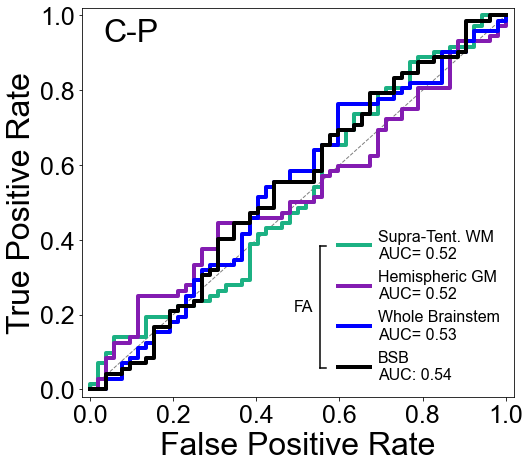

In [90]:
#### plot everything together!

fig = plt.figure(figsize=(10, 9))

plot_area = [0.2, 0.2, 0.6, 0.6] 
ax = fig.add_axes(plot_area)

line_weight_large = 4
line_weight_small = 4

# Identity line
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')

#################### FA ####################

# Plot TractSeg ROC curve
plt.plot(fpr_tractseg_cp, tpr_tractseg_cp, color='#1cb183', lw=line_weight_large, label='Supra-Tent. WM\nAUC= {:.2f}'.format(roc_auc_tractseg_cp))

# Plot Cortical WM ROC curve
plt.plot(fpr_cwm_cp, tpr_cwm_cp, color='#831CB1', lw=line_weight_large, label='Hemispheric GM\nAUC= {:.2f}'.format(roc_auc_cwm_cp))


# Plot brainstem ROC curve
plt.plot(fpr_brainstem_cp, tpr_brainstem_cp, color='blue', lw=line_weight_large, label='Whole Brainstem\nAUC= {:.2f}'.format(roc_auc_brainstem_cp))


# Plot BSB ROC curve
plt.plot(fpr_cp, tpr_cp, color='black', lw=line_weight_large, label='BSB\nAUC: {:.2f}'.format(roc_auc_cp))


plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate', fontsize=32,fontweight='regular')
plt.xticks(fontsize=25,fontweight='regular')
plt.yticks(fontsize=25,fontweight='regular')
plt.ylabel('True Positive Rate', fontsize=32,fontweight='regular')
#plt.title('ADNI ROC Curve', fontsize=30)
legend = plt.legend(loc="lower right", fontsize=16,prop={'size':16,'weight':'regular'}, handlelength=2, handletextpad=0.5, frameon=False)

plt.text(0.05, 0.9, 'C-P', transform=ax.transAxes, fontsize=32, fontweight='regular', verticalalignment='bottom', horizontalalignment='left', bbox=dict(facecolor='white', edgecolor='white', boxstyle='square,pad=0.2', linewidth=0.5))


bracket_x = 0.55 
bracket_top = 0.388 
bracket_bottom = 0.075

plt.plot([bracket_x, bracket_x], [bracket_bottom, bracket_top], color='black', lw=1.5, transform=plt.gca().transAxes)

#  top of the bracket
plt.plot([bracket_x, bracket_x + 0.015], [bracket_top, bracket_top], color='black', lw=1.5, transform=plt.gca().transAxes)

#  bottom of the bracket
plt.plot([bracket_x, bracket_x + 0.015], [bracket_bottom, bracket_bottom], color='black', lw=1.5, transform=plt.gca().transAxes)

plt.text(bracket_x - 0.06, (bracket_top + bracket_bottom) / 2, 'FA', va='center', transform=plt.gca().transAxes, fontsize=16)

plt.tight_layout()
plt.savefig('/Users/markolchanyi/Desktop/BSB_Figs/PPMI_ROC_CP_FA.png', dpi=300)
plt.show()


<ipython-input-91-551da0f42f68>:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


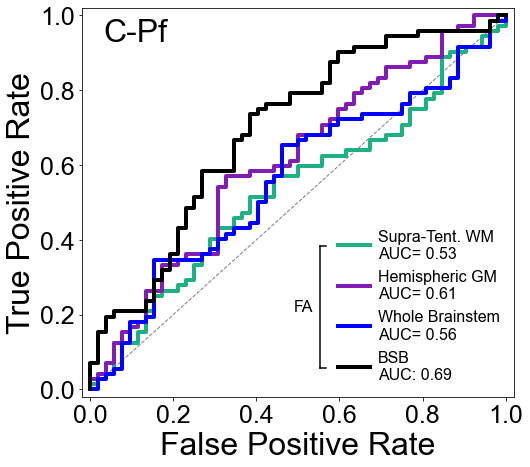

In [91]:
#### plot everything together!

fig = plt.figure(figsize=(10, 9))

plot_area = [0.2, 0.2, 0.6, 0.6] 
ax = fig.add_axes(plot_area)

line_weight_large = 4
line_weight_small = 4

# Identity line
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')

#################### FA ####################

# Plot TractSeg ROC curve
plt.plot(fpr_tractseg_cpf, tpr_tractseg_cpf, color='#1cb183', lw=line_weight_large, label='Supra-Tent. WM\nAUC= {:.2f}'.format(roc_auc_tractseg_cpf))

# Plot Cortical WM ROC curve
plt.plot(fpr_cwm_cpf, tpr_cwm_cpf, color='#831CB1', lw=line_weight_large, label='Hemispheric GM\nAUC= {:.2f}'.format(roc_auc_cwm_cpf))


# Plot brainstem ROC curve
plt.plot(fpr_brainstem_cpf, tpr_brainstem_cpf, color='blue', lw=line_weight_large, label='Whole Brainstem\nAUC= {:.2f}'.format(roc_auc_brainstem_cpf))


# Plot BSB ROC curve
plt.plot(fpr_cpf, tpr_cpf, color='black', lw=line_weight_large, label='BSB\nAUC: {:.2f}'.format(roc_auc_cpf))


plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate', fontsize=32,fontweight='regular')
plt.xticks(fontsize=25,fontweight='regular')
plt.yticks(fontsize=25,fontweight='regular')
plt.ylabel('True Positive Rate', fontsize=32,fontweight='regular')
#plt.title('ADNI ROC Curve', fontsize=30)
legend = plt.legend(loc="lower right", fontsize=16,prop={'size':16,'weight':'regular'}, handlelength=2, handletextpad=0.5, frameon=False)

plt.text(0.05, 0.9, 'C-Pf', transform=ax.transAxes, fontsize=32, fontweight='regular', verticalalignment='bottom', horizontalalignment='left', bbox=dict(facecolor='white', edgecolor='white', boxstyle='square,pad=0.2', linewidth=0.5))


bracket_x = 0.55  
bracket_top = 0.388  
bracket_bottom = 0.075 

plt.plot([bracket_x, bracket_x], [bracket_bottom, bracket_top], color='black', lw=1.5, transform=plt.gca().transAxes)

#  top of the bracket
plt.plot([bracket_x, bracket_x + 0.015], [bracket_top, bracket_top], color='black', lw=1.5, transform=plt.gca().transAxes)

#  bottom of the bracket
plt.plot([bracket_x, bracket_x + 0.015], [bracket_bottom, bracket_bottom], color='black', lw=1.5, transform=plt.gca().transAxes)


plt.text(bracket_x - 0.06, (bracket_top + bracket_bottom) / 2, 'FA', va='center', transform=plt.gca().transAxes, fontsize=16)

plt.tight_layout()
plt.savefig('/Users/markolchanyi/Desktop/BSB_Figs/PPMI_ROC_CPf_FA.png', dpi=300)
plt.show()


<ipython-input-92-9efe0077d09a>:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


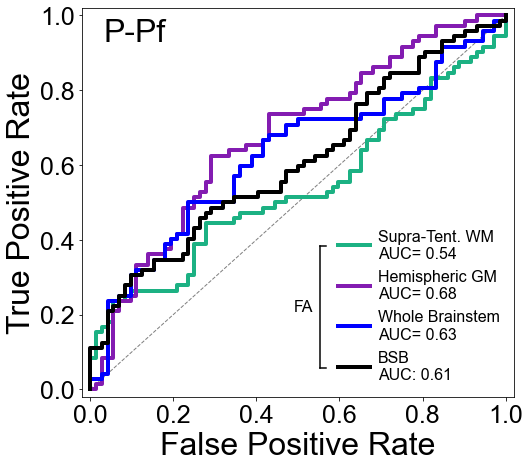

In [92]:
#### plot everything together!

fig = plt.figure(figsize=(10, 9))

plot_area = [0.2, 0.2, 0.6, 0.6] 
ax = fig.add_axes(plot_area)

line_weight_large = 4
line_weight_small = 4

# Identity line
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')

#################### FA ####################

# Plot TractSeg ROC curve
plt.plot(fpr_tractseg_ppf, tpr_tractseg_ppf, color='#1cb183', lw=line_weight_large, label='Supra-Tent. WM\nAUC= {:.2f}'.format(roc_auc_tractseg_ppf))

# Plot Cortical WM ROC curve
plt.plot(fpr_cwm_ppf, tpr_cwm_ppf, color='#831CB1', lw=line_weight_large, label='Hemispheric GM\nAUC= {:.2f}'.format(roc_auc_cwm_ppf))


# Plot brainstem ROC curve
plt.plot(fpr_brainstem_ppf, tpr_brainstem_ppf, color='blue', lw=line_weight_large, label='Whole Brainstem\nAUC= {:.2f}'.format(roc_auc_brainstem_ppf))


# Plot BSB ROC curve
plt.plot(fpr_ppf, tpr_ppf, color='black', lw=line_weight_large, label='BSB\nAUC: {:.2f}'.format(roc_auc_ppf))


plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate', fontsize=32,fontweight='regular')
plt.xticks(fontsize=25,fontweight='regular')
plt.yticks(fontsize=25,fontweight='regular')
plt.ylabel('True Positive Rate', fontsize=32,fontweight='regular')
#plt.title('ADNI ROC Curve', fontsize=30)
legend = plt.legend(loc="lower right", fontsize=16,prop={'size':16,'weight':'regular'}, handlelength=2, handletextpad=0.5, frameon=False)

plt.text(0.05, 0.9, 'P-Pf', transform=ax.transAxes, fontsize=32, fontweight='regular', verticalalignment='bottom', horizontalalignment='left', bbox=dict(facecolor='white', edgecolor='white', boxstyle='square,pad=0.2', linewidth=0.5))

bracket_x = 0.55 
bracket_top = 0.388 
bracket_bottom = 0.075 

plt.plot([bracket_x, bracket_x], [bracket_bottom, bracket_top], color='black', lw=1.5, transform=plt.gca().transAxes)

# top of the bracket
plt.plot([bracket_x, bracket_x + 0.015], [bracket_top, bracket_top], color='black', lw=1.5, transform=plt.gca().transAxes)

# bottom of the bracket
plt.plot([bracket_x, bracket_x + 0.015], [bracket_bottom, bracket_bottom], color='black', lw=1.5, transform=plt.gca().transAxes)


plt.text(bracket_x - 0.06, (bracket_top + bracket_bottom) / 2, 'FA', va='center', transform=plt.gca().transAxes, fontsize=16)

plt.tight_layout()
plt.savefig('/Users/markolchanyi/Desktop/BSB_Figs/PPMI_ROC_PPf_FA.png', dpi=300)
plt.show()


<ipython-input-93-171bbe1436a7>:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


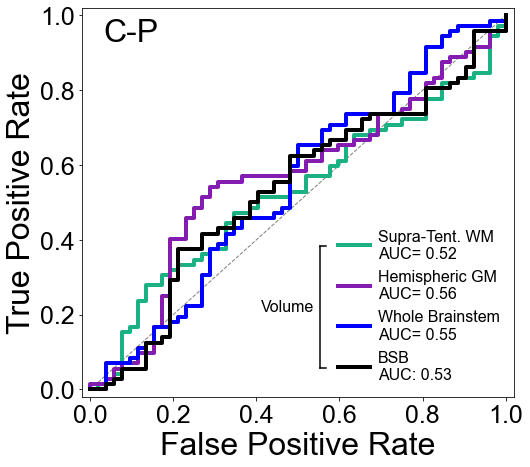

In [93]:
#### plot everything together!

fig = plt.figure(figsize=(10, 9))

plot_area = [0.2, 0.2, 0.6, 0.6]
ax = fig.add_axes(plot_area)

line_weight_large = 4
line_weight_small = 4

# Identity line
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')

#################### FA ####################

# Plot TractSeg ROC curve
plt.plot(fpr_tractseg_cp_volume, tpr_tractseg_cp_volume, color='#1cb183', lw=line_weight_large, label='Supra-Tent. WM\nAUC= {:.2f}'.format(roc_auc_tractseg_cp_volume))

# Plot Cortical WM ROC curve
plt.plot(fpr_cwm_cp_volume, tpr_cwm_cp_volume, color='#831CB1', lw=line_weight_large, label='Hemispheric GM\nAUC= {:.2f}'.format(roc_auc_cwm_cp_volume))


# Plot brainstem ROC curve
plt.plot(fpr_brainstem_cp_volume, tpr_brainstem_cp_volume, color='blue', lw=line_weight_large, label='Whole Brainstem\nAUC= {:.2f}'.format(roc_auc_brainstem_cp_volume))


# Plot BSB ROC curve
plt.plot(fpr_cp_volume, tpr_cp_volume, color='black', lw=line_weight_large, label='BSB\nAUC: {:.2f}'.format(roc_auc_cp_volume))

# Set labels and legends
plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate', fontsize=32,fontweight='regular')
plt.xticks(fontsize=25,fontweight='regular')
plt.yticks(fontsize=25,fontweight='regular')
plt.ylabel('True Positive Rate', fontsize=32,fontweight='regular')
#plt.title('ADNI ROC Curve', fontsize=30)
legend = plt.legend(loc="lower right", fontsize=16,prop={'size':16,'weight':'regular'}, handlelength=2, handletextpad=0.5, frameon=False)

plt.text(0.05, 0.9, 'C-P', transform=ax.transAxes, fontsize=32, fontweight='regular', verticalalignment='bottom', horizontalalignment='left', bbox=dict(facecolor='white', edgecolor='white', boxstyle='square,pad=0.2', linewidth=0.5))


bracket_x = 0.55 
bracket_top = 0.388 
bracket_bottom = 0.075 


plt.plot([bracket_x, bracket_x], [bracket_bottom, bracket_top], color='black', lw=1.5, transform=plt.gca().transAxes)

#  top of the bracket
plt.plot([bracket_x, bracket_x + 0.015], [bracket_top, bracket_top], color='black', lw=1.5, transform=plt.gca().transAxes)

#  bottom of the bracket
plt.plot([bracket_x, bracket_x + 0.015], [bracket_bottom, bracket_bottom], color='black', lw=1.5, transform=plt.gca().transAxes)


plt.text(bracket_x - 0.135, (bracket_top + bracket_bottom) / 2, 'Volume', va='center', transform=plt.gca().transAxes, fontsize=16)

plt.tight_layout()
plt.savefig('/Users/markolchanyi/Desktop/BSB_Figs/PPMI_ROC_CP_Volume.png', dpi=300)
plt.show()


<ipython-input-94-1364e91a8470>:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


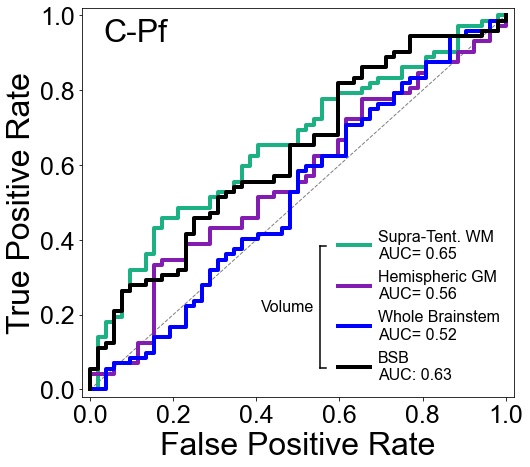

In [94]:
#### plot everything together!

fig = plt.figure(figsize=(10, 9))

plot_area = [0.2, 0.2, 0.6, 0.6]
ax = fig.add_axes(plot_area)

line_weight_large = 4
line_weight_small = 4

# Identity line
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')

#################### FA ####################

# Plot TractSeg ROC curve
plt.plot(fpr_tractseg_cpf_volume, tpr_tractseg_cpf_volume, color='#1cb183', lw=line_weight_large, label='Supra-Tent. WM\nAUC= {:.2f}'.format(roc_auc_tractseg_cpf_volume))

# Plot Cortical WM ROC curve
plt.plot(fpr_cwm_cpf_volume, tpr_cwm_cpf_volume, color='#831CB1', lw=line_weight_large, label='Hemispheric GM\nAUC= {:.2f}'.format(roc_auc_cwm_cpf_volume))


# Plot brainstem ROC curve
plt.plot(fpr_brainstem_cpf_volume, tpr_brainstem_cpf_volume, color='blue', lw=line_weight_large, label='Whole Brainstem\nAUC= {:.2f}'.format(roc_auc_brainstem_cpf_volume))


# Plot BSB ROC curve
plt.plot(fpr_cpf_volume, tpr_cpf_volume, color='black', lw=line_weight_large, label='BSB\nAUC: {:.2f}'.format(roc_auc_cpf_volume))


plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate', fontsize=32,fontweight='regular')
plt.xticks(fontsize=25,fontweight='regular')
plt.yticks(fontsize=25,fontweight='regular')
plt.ylabel('True Positive Rate', fontsize=32,fontweight='regular')
#plt.title('ADNI ROC Curve', fontsize=30)
legend = plt.legend(loc="lower right", fontsize=16,prop={'size':16,'weight':'regular'}, handlelength=2, handletextpad=0.5, frameon=False)

plt.text(0.05, 0.9, 'C-Pf', transform=ax.transAxes, fontsize=32, fontweight='regular', verticalalignment='bottom', horizontalalignment='left', bbox=dict(facecolor='white', edgecolor='white', boxstyle='square,pad=0.2', linewidth=0.5))


bracket_x = 0.55 
bracket_top = 0.388  
bracket_bottom = 0.075 


plt.plot([bracket_x, bracket_x], [bracket_bottom, bracket_top], color='black', lw=1.5, transform=plt.gca().transAxes)

#  top of the bracket
plt.plot([bracket_x, bracket_x + 0.015], [bracket_top, bracket_top], color='black', lw=1.5, transform=plt.gca().transAxes)

#  bottom of the bracket
plt.plot([bracket_x, bracket_x + 0.015], [bracket_bottom, bracket_bottom], color='black', lw=1.5, transform=plt.gca().transAxes)


plt.text(bracket_x - 0.135, (bracket_top + bracket_bottom) / 2, 'Volume', va='center', transform=plt.gca().transAxes, fontsize=16)

plt.tight_layout()
plt.savefig('/Users/markolchanyi/Desktop/BSB_Figs/PPMI_ROC_CPf_Volume.png', dpi=300)
plt.show()


<ipython-input-95-09c09f2c8ad5>:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


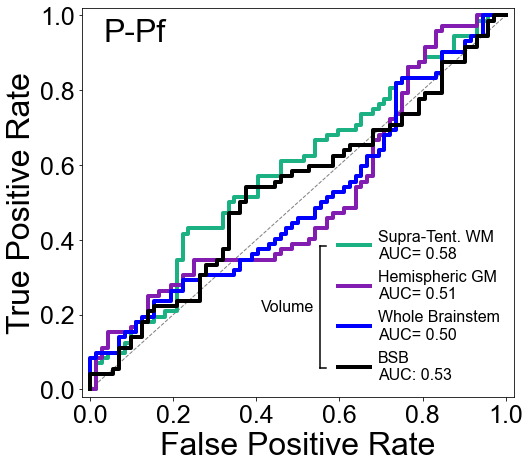

In [95]:
#### plot everything together!

fig = plt.figure(figsize=(10, 9))

plot_area = [0.2, 0.2, 0.6, 0.6]
ax = fig.add_axes(plot_area)

line_weight_large = 4
line_weight_small = 4

# Identity line
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')

#################### FA ####################

# Plot TractSeg ROC curve
plt.plot(fpr_tractseg_ppf_volume, tpr_tractseg_ppf_volume, color='#1cb183', lw=line_weight_large, label='Supra-Tent. WM\nAUC= {:.2f}'.format(roc_auc_tractseg_ppf_volume))

# Plot Cortical WM ROC curve
plt.plot(fpr_cwm_ppf_volume, tpr_cwm_ppf_volume, color='#831CB1', lw=line_weight_large, label='Hemispheric GM\nAUC= {:.2f}'.format(roc_auc_cwm_ppf_volume))


# Plot brainstem ROC curve
plt.plot(fpr_brainstem_ppf_volume, tpr_brainstem_ppf_volume, color='blue', lw=line_weight_large, label='Whole Brainstem\nAUC= {:.2f}'.format(roc_auc_brainstem_ppf_volume))


# Plot BSB ROC curve
plt.plot(fpr_ppf_volume, tpr_ppf_volume, color='black', lw=line_weight_large, label='BSB\nAUC: {:.2f}'.format(roc_auc_ppf_volume))


plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate', fontsize=32,fontweight='regular')
plt.xticks(fontsize=25,fontweight='regular')
plt.yticks(fontsize=25,fontweight='regular')
plt.ylabel('True Positive Rate', fontsize=32,fontweight='regular')
#plt.title('ADNI ROC Curve', fontsize=30)
legend = plt.legend(loc="lower right", fontsize=16,prop={'size':16,'weight':'regular'}, handlelength=2, handletextpad=0.5, frameon=False)

plt.text(0.05, 0.9, 'P-Pf', transform=ax.transAxes, fontsize=32, fontweight='regular', verticalalignment='bottom', horizontalalignment='left', bbox=dict(facecolor='white', edgecolor='white', boxstyle='square,pad=0.2', linewidth=0.5))


bracket_x = 0.55  
bracket_top = 0.388 
bracket_bottom = 0.075  


plt.plot([bracket_x, bracket_x], [bracket_bottom, bracket_top], color='black', lw=1.5, transform=plt.gca().transAxes)

#  top of the bracket
plt.plot([bracket_x, bracket_x + 0.015], [bracket_top, bracket_top], color='black', lw=1.5, transform=plt.gca().transAxes)

#  bottom of the bracket
plt.plot([bracket_x, bracket_x + 0.015], [bracket_bottom, bracket_bottom], color='black', lw=1.5, transform=plt.gca().transAxes)


plt.text(bracket_x - 0.135, (bracket_top + bracket_bottom) / 2, 'Volume', va='center', transform=plt.gca().transAxes, fontsize=16)

plt.tight_layout()
plt.savefig('/Users/markolchanyi/Desktop/BSB_Figs/PPMI_ROC_PPf_Volume.png', dpi=300)
plt.show()


In [96]:
########### FA ################## 
################ for C-P #######################

p_delong_tractseg_bsb_cp = delong_roc_test(np.array(all_y_test_cp), np.array(all_y_scores_cp),np.array(all_y_scores_tractseg_cp))[0,0]
print("(FA) Tractseg-BSB C-P p value: ", (10 ** p_delong_tractseg_bsb_cp))

p_delong_bsb_bs_cp = delong_roc_test(np.array(all_y_test_cp), np.array(all_y_scores_cp),np.array(all_y_scores_brainstem_cp))[0,0]
print("(FA) Brainstem-BSB C-P p value: ", (10 ** p_delong_bsb_bs_cp))

p_delong_bsb_cwm_cp = delong_roc_test(np.array(all_y_test_cp), np.array(all_y_scores_cp),np.array(all_y_scores_cwm_cp))[0,0]
print("(FA) CWM-BSB C-P p value: ", (10 ** p_delong_bsb_cwm_cp))

################################################

print(" ")

################ for C-Pf #######################

p_delong_tractseg_bsb_cpf = delong_roc_test(np.array(all_y_test_cpf), np.array(all_y_scores_cpf),np.array(all_y_scores_tractseg_cpf))[0,0]
print("(FA) Tractseg-BSB C-Pf p value: ", (10 ** p_delong_tractseg_bsb_cpf))

p_delong_bsb_bs_cpf = delong_roc_test(np.array(all_y_test_cpf), np.array(all_y_scores_cpf),np.array(all_y_scores_brainstem_cpf))[0,0]
print("(FA) Brainstem-BSB C-Pf p value: ", (10 ** p_delong_bsb_bs_cpf))

p_delong_bsb_cwm_cpf = delong_roc_test(np.array(all_y_test_cpf), np.array(all_y_scores_cpf),np.array(all_y_scores_cwm_cpf))[0,0]
print("(FA) CWM-BSB C-Pf p value: ", (10 ** p_delong_bsb_cwm_cpf))

################################################

print(" ")

################ for P-Pf #######################

p_delong_tractseg_bsb_ppf = delong_roc_test(np.array(all_y_test_ppf), np.array(all_y_scores_ppf),np.array(all_y_scores_tractseg_ppf))[0,0]
print("(FA) Tractseg-BSB P-Pf p value: ", (10 ** p_delong_tractseg_bsb_ppf))

p_delong_bsb_bs_ppf = delong_roc_test(np.array(all_y_test_ppf), np.array(all_y_scores_ppf),np.array(all_y_scores_brainstem_ppf))[0,0]
print("(FA) Brainstem-BSB P-Pf p value: ", (10 ** p_delong_bsb_bs_ppf))

p_delong_bsb_cwm_ppf = delong_roc_test(np.array(all_y_test_ppf), np.array(all_y_scores_ppf),np.array(all_y_scores_cwm_ppf))[0,0]
print("(FA) CWM-BSB P-Pf p value: ", (10 ** p_delong_bsb_cwm_ppf))

################################################

print(" ")
print(" ")
print(" ")

########### VOLUME ################## 
################ for C-P #######################

p_delong_tractseg_bsb_cp_volume = delong_roc_test(np.array(all_y_test_cp_volume), np.array(all_y_scores_cp_volume),np.array(all_y_scores_tractseg_cp_volume))[0,0]
print("(Volume) Tractseg-BSB C-P p value: ", (10 ** p_delong_tractseg_bsb_cp_volume))

p_delong_bsb_bs_cp_volume = delong_roc_test(np.array(all_y_test_cp_volume), np.array(all_y_scores_cp_volume),np.array(all_y_scores_brainstem_cp_volume))[0,0]
print("(Volume) Brainstem-BSB C-P p value: ", (10 ** p_delong_bsb_bs_cp_volume))

p_delong_bsb_cwm_cp_volume = delong_roc_test(np.array(all_y_test_cp_volume), np.array(all_y_scores_cp_volume),np.array(all_y_scores_cwm_cp_volume))[0,0]
print("(Volume) CWM-BSB C-P p value: ", (10 ** p_delong_bsb_cwm_cp_volume))

################################################

print(" ")

################ for C-Pf #######################

p_delong_tractseg_bsb_cpf_volume = delong_roc_test(np.array(all_y_test_cpf_volume), np.array(all_y_scores_cpf_volume),np.array(all_y_scores_tractseg_cpf_volume))[0,0]
print("(Volume) Tractseg-BSB C-Pf p value: ", (10 ** p_delong_tractseg_bsb_cpf_volume))

p_delong_bsb_bs_cpf_volume = delong_roc_test(np.array(all_y_test_cpf_volume), np.array(all_y_scores_cpf_volume),np.array(all_y_scores_brainstem_cpf_volume))[0,0]
print("(Volume) Brainstem-BSB C-Pf p value: ", (10 ** p_delong_bsb_bs_cpf_volume))

p_delong_bsb_cwm_cpf_volume = delong_roc_test(np.array(all_y_test_cpf_volume), np.array(all_y_scores_cpf_volume),np.array(all_y_scores_cwm_cpf_volume))[0,0]
print("(Volume) CWM-BSB C-Pf p value: ", (10 ** p_delong_bsb_cwm_cpf_volume))

################################################

print(" ")

################ for P-Pf #######################

p_delong_tractseg_bsb_ppf_volume = delong_roc_test(np.array(all_y_test_ppf_volume), np.array(all_y_scores_ppf_volume),np.array(all_y_scores_tractseg_ppf_volume))[0,0]
print("(Volume) Tractseg-BSB P-Pf p value: ", (10 ** p_delong_tractseg_bsb_ppf_volume))

p_delong_bsb_bs_ppf_volume = delong_roc_test(np.array(all_y_test_ppf_volume), np.array(all_y_scores_ppf_volume),np.array(all_y_scores_brainstem_ppf_volume))[0,0]
print("(Volume) Brainstem-BSB P-Pf p value: ", (10 ** p_delong_bsb_bs_ppf_volume))

p_delong_bsb_cwm_ppf_volume = delong_roc_test(np.array(all_y_test_ppf_volume), np.array(all_y_scores_ppf_volume),np.array(all_y_scores_cwm_ppf_volume))[0,0]
print("(Volume) CWM-BSB P-Pf p value: ", (10 ** p_delong_bsb_cwm_ppf_volume))

################################################

(FA) Tractseg-BSB C-P p value:  0.8360804230259893
(FA) Brainstem-BSB C-P p value:  0.9468463957173597
(FA) CWM-BSB C-P p value:  0.7932796871143551
 
(FA) Tractseg-BSB C-Pf p value:  0.0240694032895651
(FA) Brainstem-BSB C-Pf p value:  0.0648119794241607
(FA) CWM-BSB C-Pf p value:  0.21951554058396977
 
(FA) Tractseg-BSB P-Pf p value:  0.21492371164259846
(FA) Brainstem-BSB P-Pf p value:  0.7756830436951189
(FA) CWM-BSB P-Pf p value:  0.26599439608813535
 
 
 
(Volume) Tractseg-BSB C-P p value:  0.8897138593517312
(Volume) Brainstem-BSB C-P p value:  0.8823033403099388
(Volume) CWM-BSB C-P p value:  0.7011753797581362
 
(Volume) Tractseg-BSB C-Pf p value:  0.7452397917452633
(Volume) Brainstem-BSB C-Pf p value:  0.0736765229030998
(Volume) CWM-BSB C-Pf p value:  0.2883532692574047
 
(Volume) Tractseg-BSB P-Pf p value:  0.430930847177427
(Volume) Brainstem-BSB P-Pf p value:  0.6568205547984842
(Volume) CWM-BSB P-Pf p value:  0.7309115076674485
